# Top Ranked UFC Athletes by Division

In this project, I will examine the UFC's top 15 ranked athletes in each of the eight male weight divisions to determine if different characteristics contribute to success at different weightclasses. Note I will be analyzing the champion of the division as well as the top 15 ranked athletes in every division (rankings don't includ the champion), meaning I will be analyzing 16 athletes per division. Note that this data was collected on December 31, 2020 from the [UFC's website](https://www.ufc.com/rankings).

The eight UFC male weight divisions are as follows:
- Flyweight = 125 pound weight limit
- Bantamweight = 135 pound weight limit
- Featherweight = 145 pound weight limit
- Lightweight = 155 pound weight limit
- Welterweight = 170 pound weight limit
- Middleweight = 185 pound weight limit
- Light Heavyweight = 205 pound weight limit
- Heavyweight = 265 pound weight limit

Note that most MMA athletes cut a lot of weight before their fights so they can compete against smaller opponents. The weight cutting process generally involves the following steps:
1. Cut as much fat as possible within a 5-8 week training period.
2. During the few days leading up to the fight, sweat out a significant amount of water weight using a sauna. Then rapidly rehydrate after weighing in order to be significantly heavier while fighting.

After the rehydration process, most athletes weigh much more in the cage than they do when they are officially weighed the day before their fights. According to this [article](https://www.mmafighting.com/2019/1/1/18163282/ufc-232-fight-night-weights-cris-cyborg-only-had-4-5-pound-advantage-on-amanda-nunes#:~:text=Cyborg%20weighed%20160.5%20pounds%20in,pounds%2C%20just%204.5%20pounds%20less.), which contains weigh-in weights as well as the fight night weights for every athlete on UFC 232, Alexander Volkanovski weighed 166.5 pounds while fighting in the cage despite making the 145 during weigh-ins the day beforehand, meaning he gained 14.8% of his bodyweight in a single day after the rehydration process.

## 1. Preparing the Data for Analysis

The first step for this project involves importing the appropriate libraries and reading in the datasets containing the male UFC rankings. This will help me determine which aspects of the dataset are most pertinent to my analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
import datetime
from dateutil.relativedelta import relativedelta
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.image import imread
import re

male_ranks = pd.read_excel("male_ranks.xlsx")

## a) First Look at the Datasets

Next, I will examine the dataset to better understand the information I am working with. Note that I personally collected the information from the UFC's official website and stored it in an excel datasheet.

In [2]:
male_ranks.head()

,Name,Division,Rank,UFC Fights,UFC Wins,UFC Losses,UFC Draws,UFC NC,KO Wins,TKO Wins,Sub Wins,Dec Wins,Height,Reach,Birthday,Country,Region,MMA Gym
0,Deiveson Figueiredo,Flyweight,0,11,9,1,1,0,0,4,3,2,65.0,68.0,1987-12-18,Brazil,Para,Team Figueiredo
1,Brandon Moreno,Flyweight,1,10,6,2,2,0,0,1,2,3,67.0,70.0,1993-12-07,Mexico,Baja California,Entram Gym
2,Joseph Benavidez,Flyweight,2,20,15,5,0,0,0,5,1,9,64.0,65.0,1984-07-31,United States,California,Xtreme Couture
3,Askar Askarov,Flyweight,3,3,2,0,1,0,0,0,0,2,66.0,67.0,1992-10-09,Russia,Dagestan,Eagles MMA
4,Alex Perez,Flyweight,4,9,7,2,0,0,1,1,3,2,66.0,65.0,1992-03-21,United States,California,Team Oyama


Many of the columns in these datasets are self-explanatory, but I'll explain the columns that require additional MMA knowledge to understand:
- Rank = Rank 0 represents a champion, while ranks 1-10 represent the top ten contenders for the belt. Since rankings are used to help determine which contenders should fight the champion (or which ranked athletes should fight each other to update the rankings), the champion is not ranked.
- UFC Scoring = In the UFC, an athlete can either win, lose, draw, or receive a NC. 
    - Win = Athlete either outscours his/her opponent (determined by a panel of three judges) or finishes their opponent via KO/TKO or submission.
    - Loss = Athlete is either outscored or finished. In rare instances, an athlete can lose a fight by disqualification (DQ) if they intentionally foul their opponent and their opponent cannot continue fighting. 
    - Draw = Both athletes score the same number of points.
    - No Contest (NC) = Results of a match is nullified. These occur when a fighter unintentionally fouls his/her opponent in a manner that prevents the opponent from fighting or the winning athlete tests positive for an illegal substance in a post-fight drug test.
- KO Win = Winning athlete knocks his opponent unconscious with strike(s).
- TKO Win = A ref or an athletes corner determines that the losing athlete is no longer capable of fighting due to sustained injuries from strikes. In rare instances, the athlete receiving the strikes will voluntarily end a fight by tapping.
- Sub Win = An athlete chokes his/her opponent unconscious, breaks his/her opponent's limb with a submission, or forces his/her opponent to tap to avoid getting choked or submitted.
- Dec Win = An athlete wins by points, as determined by a panel of three judges using a 10-9 scoring system.

Note that in this project, I will be examining the fighters' UFC record rather than their overall MMA record. All UFC fighters have professional fights from other MMA organizations that are part of their overall record, but since the level of competition differs between different MMA organizations, I will only examine each athlete's UFC record.

## b) Creating Useful Statistics

In order to better gauge each athlete's ability, I will calculate a few statistics:
- Finishes = The number of fights that are finished by TKO, KO, or submission.
- Finish Rate = The percentage fights an athlete finishes by TKO, KO, or submission.
- KO/TKO Wins = Combined KO and TKO wins.
- Win % = The percentage of fights that the athlete has won. This calculation does not include draws and no contests but rather consists of the ratio of wins to losses.
- Win Finish Rate = The percentage of wins that the athlete finishes by either KO or submission.
- Win KO/TKO % = The percentage of wins that the athlete finished by KO/TKO.
- Win KO % = The percentage of wins that the athlete finished by KO.
- Win TKO % = The percentage of wins that the athlete finished by TKO.
- Win Sub % = The percentage of wins that the athlete finished by submission.
- Ape Index = The ratio of reach to height. The average man has an ape index between 1.02 and 1.03, although ape index greatly varies by ethnicity. Higher ape indices are generally considered beneficial in MMA.
- Age = Much easier to analyze than birthdays.

In [3]:
# Finishes
male_ranks["Finishes"] = male_ranks["TKO Wins"] + male_ranks["KO Wins"] + male_ranks["Sub Wins"]

In [4]:
# Finish Rate
male_ranks["Finish Rate"] = round((male_ranks["Finishes"] / male_ranks["UFC Fights"]) * 100, 1)

In [5]:
# KO/TKO Wins
male_ranks["KO/TKO Wins"] = male_ranks["KO Wins"] + male_ranks["TKO Wins"]

In [6]:
# Win Percentage
male_ranks["Win %"] = round((male_ranks["UFC Wins"] * 100) / (male_ranks["UFC Wins"] + male_ranks["UFC Losses"]), 1)

In [7]:
# Win Finish Rate
male_ranks["Win Finish Rate"] = round((male_ranks["Finishes"] / male_ranks["UFC Wins"]) * 100, 1)

In [8]:
# Win KO/TKO Percentage
male_ranks["Win KO/TKO %"] = round(male_ranks["KO/TKO Wins"] / male_ranks["UFC Wins"] * 100, 1)

In [9]:
# Win KO Percentage
male_ranks["Win KO %"] = round(male_ranks["KO Wins"] / male_ranks["UFC Wins"] * 100, 1)

In [10]:
# Win TKO Percentage
male_ranks["Win TKO %"] = round(male_ranks["TKO Wins"] / male_ranks["UFC Wins"] * 100, 1)

In [11]:
# Win Submission Percentage
male_ranks["Win Sub %"] = round(male_ranks["Sub Wins"] / male_ranks["UFC Wins"] * 100, 1)

In [12]:
# Ape Index
male_ranks["Ape Index"] = round(male_ranks["Reach"] / male_ranks["Height"], 3)

In [13]:
# Age
current_date = datetime.datetime(2020, 12, 31)
male_ranks["Age"] = male_ranks["Birthday"].apply(
    lambda x: relativedelta(current_date, x).years
)

Now that I have created more useful statistics, I will not begin my analysis. 

## 2. Comparing the UFC Weight Divisions

Due to the vast difference in size between the different weight classes (the heavyweight limit is more than twice as heavy as the flyweight limit), it is possible that different statistical attributes are helpful in each weight class. In order to deterimine how beneficial each attribute is for each weight division, I will examine the correlations between rank and the other statistics.

Note that when examining the correlations between different variables, I will be operating using the following correlation coefficient principles:

| Correlation Coefficient       | Interpretation            |
|:-----------------------------:|:--------------------------|
| 0.90 to 1.00 (-0.90 to -1.00) | Very high correlation     |
| 0.70 to 0.89 (-0.70 to -0.89) | High correlation          |
| 0.50 to 0.69 (-0.50 to -0.69) | Moderate correlation      |
| 0.30 to 0.49 (-0.30 to -0.49) | Low correlation           |
| 0.00 to 0.29 (-0.00 to -0.29) | Insignificant correlation |

### a) Current UFC Roster

Before comparing the divisions to one another, I will include some additional information about the number of active fighters in each weight class, since a large roster is often used as an indicator that a given weight class is competitive. An active fighter in this context is a fighter that has fought at least one fight in the UFC during the past 18 months and is not currently serving out a suspension.

|**Division**       | **Active Male Fighters** |
|:-----------------:|:------------------------:|
| Flyweight         | 23                       |
| Bantamweight      | 76                       |
| Featherweight     | 81                       |
| Lightweight       | 75                       |
| Welterweight      | 78                       |
| Middleweight      | 62                       |
| Light Heavyweight | 42                       |
| Heavyweight       | 46                       |

The division with the smallest roster by far (only 23 athletes) is the male flyweight division, which means it is likely the least competitive weight division. This is fairly unsurprising as Dana White, the president of the UFC, has threatened to cut the flyweight division on several occassions due to it's lack of viewship compared to other weight divisions. It is also the only weight division that doesn't guarantee a slot for title fights on a PPV card (meaning the flyweight champions likely get paid much less).  The rosters for the light heavyweight and heavyweight divisions are also fairly small (42 - 46 athletes) compared to the other male weight divisions. The largest rosters—bantamweight, featherweight, lightweight, and welterweight—are all around the same size (75 - 81 athletes) and thus are likely equally competitive.

### b) Differences Between the Weight Divisions

Next, I will analyze the different weight divisions in the following two ways:
- Correlations = Calculate the correlations between rank and various statistics. Since higher-ranked athletes are considered to be better than lower-ranked athletes, these correlations can be used as an approximation for how useful a characteristic is in each division.
- Averages = Calculate the averages for various statistics in each weight division so the divisions can be compared.

First, I will calculate the correlations between rank and several of the other columns in the dataset and store that information in a list. This list will later be used to generate a plot of graphs indicating the correlations for each weight division.

In [14]:
# Correlation to examine
stats = ["UFC Fights", "Win %", "Win Finish Rate", "Win KO/TKO %", "Win KO %",
         "Win Sub %", "Height", "Reach", "Ape Index", "Age"]

# Creates a list of all the correlations between rank and the other columns
male_stats = []
male_divs = list(male_ranks["Division"].unique())
for div in male_divs:
    corrs = male_ranks[male_ranks["Division"] == div].corr()
    corrs = -corrs["Rank"]
    male_stats.append(list(corrs[stats]))

Second, I will calculate the averages for each of the target statistics by division. This information will be stored in a pandas dataframe so that I can display the information as an easily-readable table.

In [15]:
male_divisions = male_ranks.groupby("Division").agg(np.mean)
male_divisions = male_divisions[stats].round(3)
stats.remove("Ape Index") # Remove Ape Index so that it isn't rounded to the tenth's place
male_divisions[stats] = male_divisions[stats].round(1)
male_divisions = male_divisions.sort_values(by="Height") # Sorting by height as proxy for sorting by weight class

Next, I will create an autolabel function that will help me display the correlations between rank and the other columns. The autolabel function will display the correlation as text slighly above (or below if the correlation is negative) each individual bar in each bar chart.

In [16]:
def autolabel(bars):
    for bar in bars: # Loops through all bars in the chart
        
        height = round(bar.get_height(), 2) # Gets y coordinate of each individual bar
        
        if height >= 0:
            offset = (0,3) # Positions the number 3 positions above the bar if height is positive
        else:
            offset = (0,-18) # Positions the number 16 positions below the bar if height is negative
        
        ax.annotate('{}'.format(height), # Formats the text to round to the nearest hundredth's place
        xy=(bar.get_x() + bar.get_width() / 2, height), # XY Position for placing text
        xytext=offset,
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=14)

Finally, I will create a plot containing eight correlation bar charts, one for each of the eight weight divisions. I will utilize the autolabel function in this block of code to improve each chart's readability.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


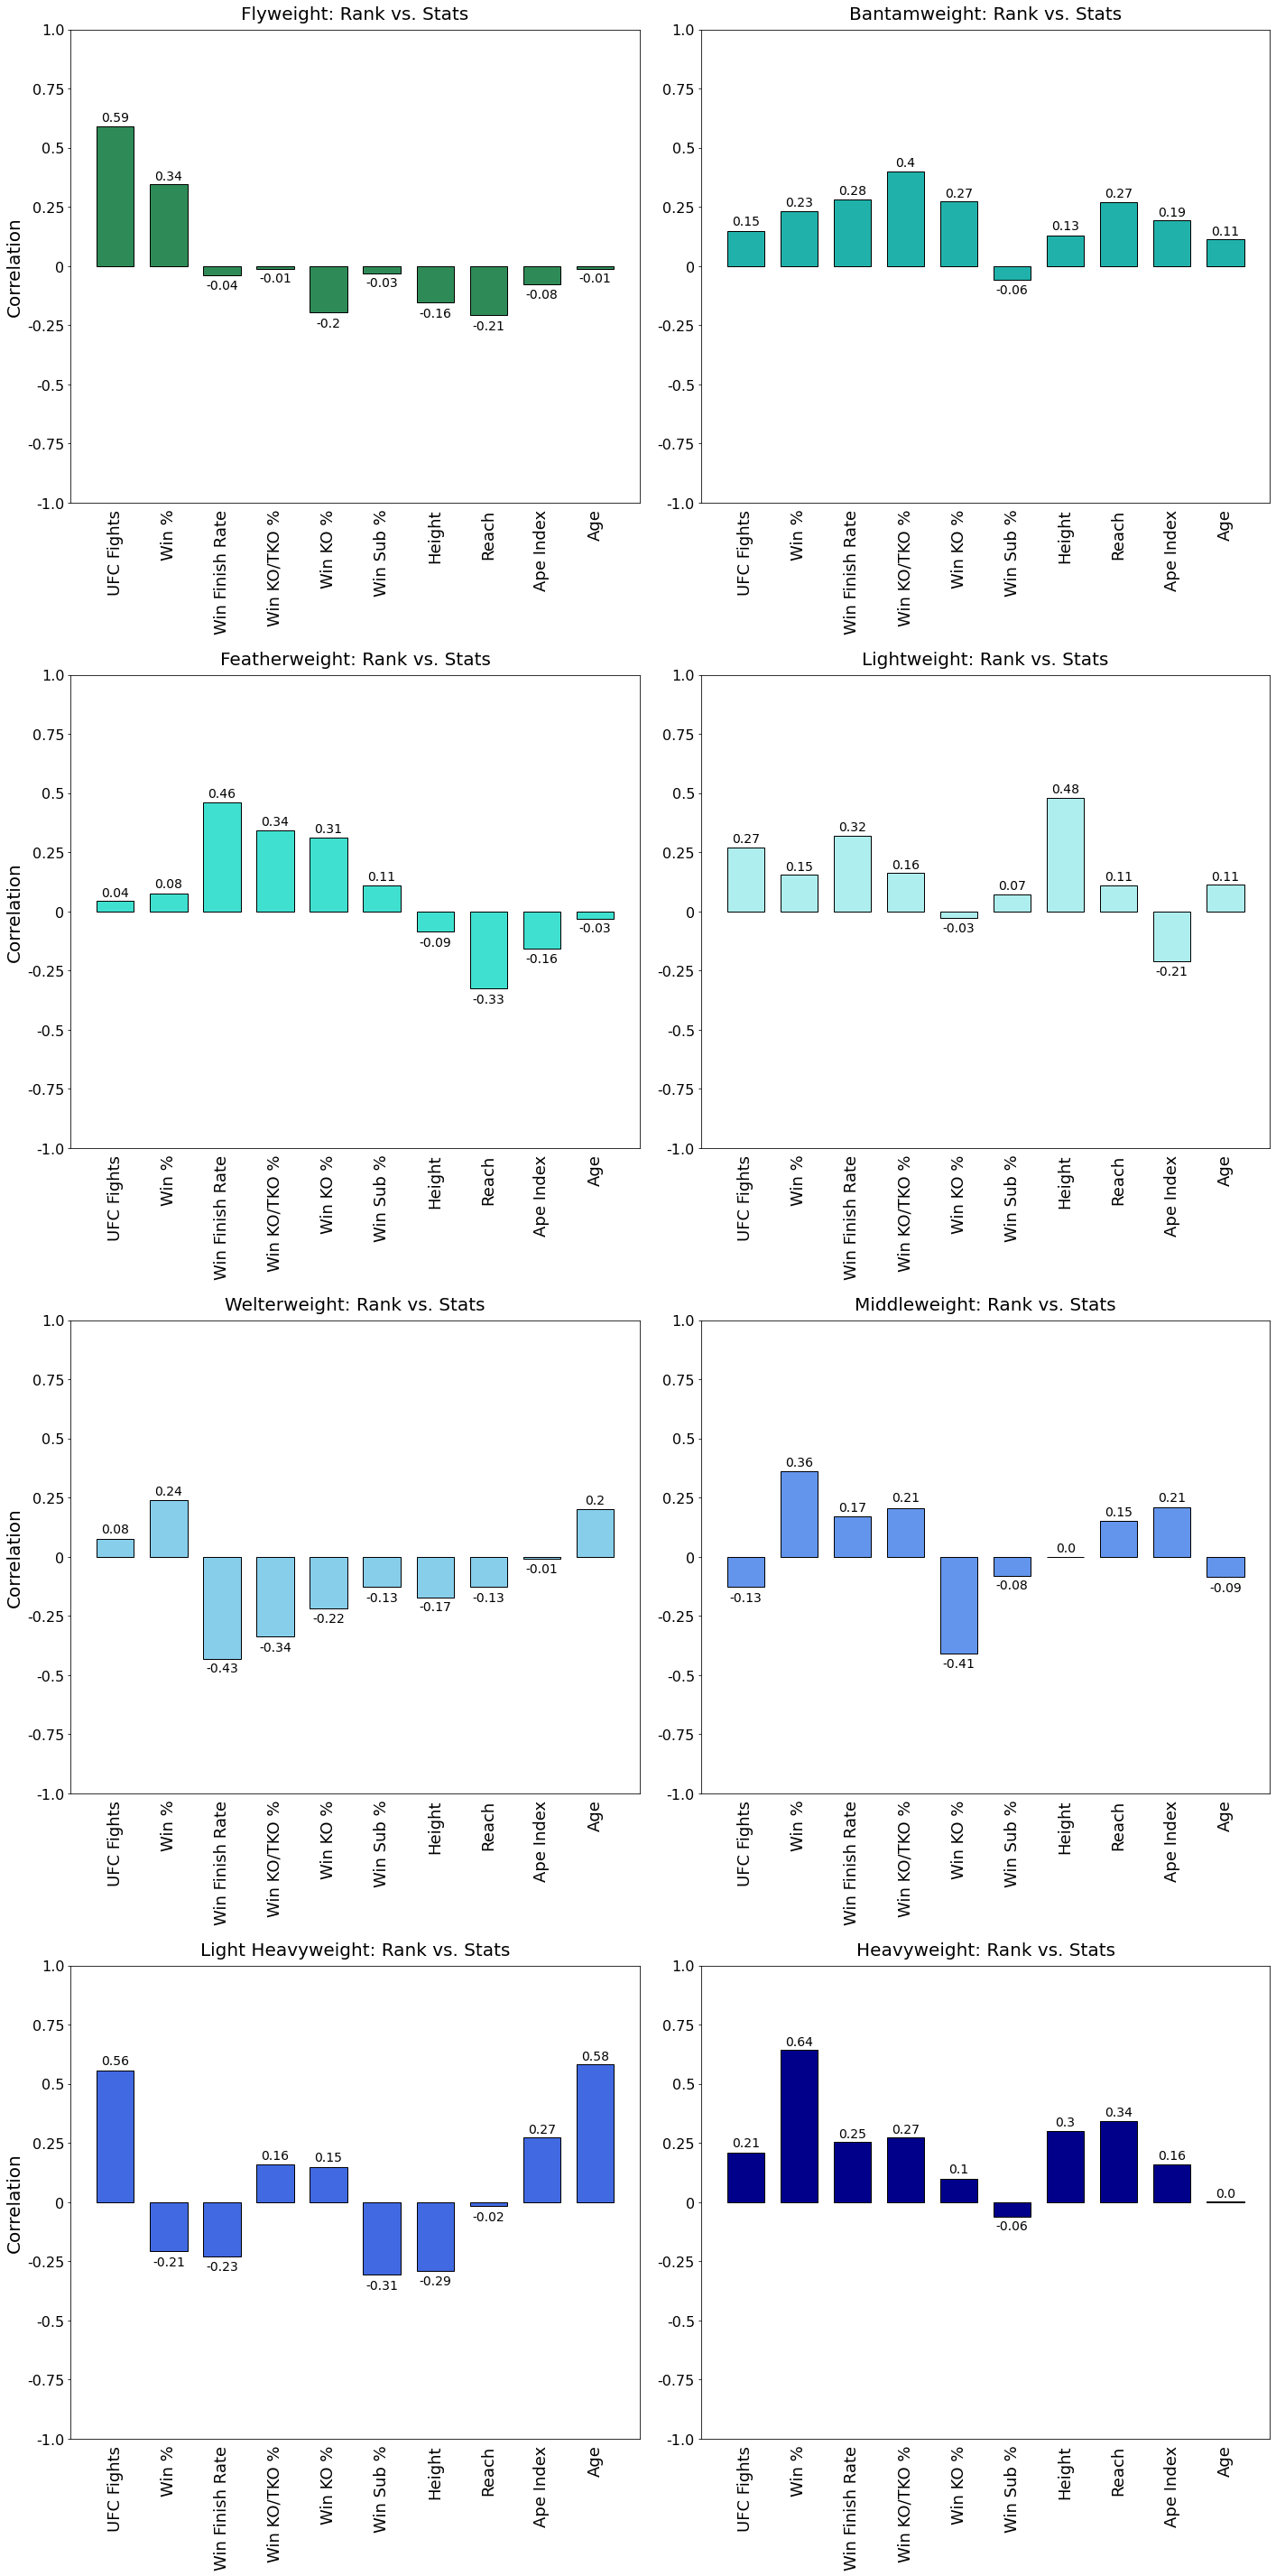

In [17]:
ind = np.arange(10)
width = (0.7)

fig = plt.figure(figsize=(20, 40))
stats = ["UFC Fights", "Win %", "Win Finish Rate", "Win KO/TKO %", "Win KO %",
         "Win Sub %", "Height", "Reach", "Ape Index", "Age"]

colors = ["seagreen", "lightseagreen", "turquoise", "paleturquoise",
          "skyblue", "cornflowerblue", "royalblue", "darkblue"]

for sp in range(8):
    ax = fig.add_subplot(4, 2, sp+1)
    plot = ax.bar(ind, male_stats[sp], width, color=colors[sp], edgecolor="black")
    
    ax.set_title(male_divs[sp] + ": Rank vs. Stats", fontsize=20, y=1.01)
    
    # Y-labels will only be generated on charts on even indices
    if sp % 2 == 0:
        ax.set_ylabel("Correlation", fontsize=20)
        
    ax.tick_params(axis="both", which="both", top=False, bottom=False, right=False)
    ax.set_xticks(ind)
    ax.set_xticklabels(stats, fontsize=18, rotation=90)
    ax.set_ylim(-1.0, 1.0)
    ax.set_yticklabels([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0], fontsize=16)
    
    autolabel(plot)

fig.tight_layout(pad=2.0)
plt.show()

In [18]:
male_divisions

,UFC Fights,Win %,Win Finish Rate,Win KO/TKO %,Win KO %,Win Sub %,Height,Reach,Ape Index,Age
Division,,,,,,,,,,
Flyweight,6.8,71.7,51.4,22.3,5.1,29.1,66.1,68.0,1.030,29.8
Bantamweight,11.6,73.3,46.1,33.4,11.1,12.7,66.8,67.9,1.016,31.4
Featherweight,11.1,83.2,49.2,33.2,11.1,16.1,69.3,71.3,1.029,30.4
Lightweight,15.7,74.4,66.2,41.0,17.7,25.2,69.4,72.2,1.040,32.2
Welterweight,15.6,76.0,55.6,35.0,16.1,20.6,71.6,74.2,1.037,33.5
Middleweight,12.1,71.9,54.6,44.7,12.1,9.8,72.5,75.5,1.042,31.2
Light Heavyweight,9.1,73.9,76.1,50.6,27.3,25.4,75.2,77.2,1.026,31.0
Heavyweight,11.5,70.5,67.8,59.4,22.3,8.4,75.4,78.9,1.047,34.4


Now that I have my charts for analysis, I will use them both to analyze each of the eleven columns in the dataset.

**1) UFC Fights**

Fighters in the lightweight and welterweight divisions (15.7 and 15.6 respectively) have many more UFC fights on average than fighters in other divisions. A high number of UFC fights could indicate either of the following:
- The division is highly competitive and thus fighters need to work their way into the top ten.
- The average fighter is older than that of fighters in other divisions and thus has had more years to compete.

Both theories have evidence to support them. As noted earlier, the lightweight and welterweight divisions have large rosters, suggesting they are rather competitive. Furthermore, the lightweight division is the third oldest division (average age 32.2) while the welterweight division is the second oldest division (average age 33.5). 

Rank is positively correlated with number of fights in every division except for the middleweight division, although this correlation is only significant in only the flyweight and light heavyweight divisions. Interestingly, the flyweight and light heavyweight divisions have the two lowest average number of UFC fights (6.8 and 9.1 respectively, which is significantly lower than the other divisions) as well as the two smallest rosters (23 and 42 respectively). Perhaps having a lot of experience in the UFC octagon is much more beneficial for athletes in less competitive divisions that it is for athletes in more competitive divisions.

**2) Win Percentage**

Unsurprisingly, there is a positive correlation between win percentage and rank in 7 out of 8 of the male divisions, although it is significant in only 3 out of 8. Note that win percentage might be skewed in favor of lower-ranked athletes as many lower-ranked athletes have yet to face elite competition. While athletes ranked in the top ten are usually fight against other top-ten ranked athletes, many low-ranked athletes (ranked between #11-15) have never fought a ranked opponent. It is fairly common for lower-ranked athletes in competitive divisions to have undefeated UFC records until they become ranked and start fighting more elite competition. Thus, while some low-ranked athletes have a better win percentage than their high-ranked counterparts, this does not mean they would be able to defeat them in a fight.

The only division with a negative correlation between win percentage and rank is the light heavyweight division, although this correlation is insignificant. Perhaps winning frequently is not as important for increasing rank in the light heavyweight division as it is for other divisions. Noteably the light heavyweight champion, Jan Błachovich, has a very low win percentage for a champion (66.7%). Interestingly, the heavyweight division has the lowest average win percentage but the highest positive correlation (0.64) between win percentage and rank. This suggests that winning frequently is much more important for heavyweights hoping to move up the rankings than it is for athletes in other divisions. 

**3) Win Finish Rate**

There appears to be a slight positive correlation between weight division and finish rate, which I will examine later. The three smallest divisions have the lowest finish rates (flyweight at 51.4%, bantamweight at 46.1%, featherwieght at 49.2%) while the two largest divisions have the highest finish rates (light heavyweight at 76.1%, heavyweight at 67.8%). Interestingly, finish rate is most highly positively correlated with rank in the featherweight division (0.46) despite the fact that this division has a very low average finishing rate. This could indicate that finishing off opponents is helpful for moving up the ranks in the featherweight division. There is also a signicant negative correlation between finish rate and rank in the welterweight (-0.43) division, which indicates that top-ranked welterweights are much more likely to win by decision (considered less risky) than low-ranked welterweights are.

**4) Win KO/TKO Percentage**

There appears to be a significant positive correlation between weight division and win KO/TKO percentage, which is unsurprising. Heavyweights are known for having high knockout rates as they have much more power than athletes from smaller weight classes. Win KO/TKO percentage is also positively correlated with rank in 6 out of 8 of the divisions, although this correlation is significant in only the bantamweight (0.40) and featherweight (0.34) divisions, which have the two lowest win KO/TKO percentages (33.4% and 33.2% respectively).

**5) Win KO Percentage**

Like win KO/TKO percentage, win KO percentage seems to be positively correlated with weight division. Since KO's usually require more power than TKO's, I hypothesize this correlation will be even higher than the correlation between TKO/KO percentage and weight division. I will investigate this is another section.

**6) Win Submission Percentage**

There might be a slight negative correlation between win submission percentage and weightclass, but it appears to be  insignificant. Additionally, there is a positive correlation between win submission percentage and rank in only 2 out of the 8 divisions and this correlation isn't significant in either division. Considering how many elite grapplers are within each division's top ten, this could indicate that grapplers are less likely to attempt finishing fights than strikers are.

**7) Height**

Height is only significantly beneficial in the lightweight (0.48) and heavyweight (0.30) divisions. There has been a trend in MMA over the past 5 years of athletes cutting more weight so that they can have a size advantage in smaller weight divisions. As a result, the average athlete in each division has gotten taller over time. However, this strategy doesn't seem to be working, as half of the divisions have a negative correlation between height and rank. 

**8) Reach**

Rather surprisingly, reach and rank are negatively correlated in half of the divisions. Reach is frequently stated as  an important statistic in combat sports as athletes with long reaches have an easier time punching their opponents while standing outside of an opponents' punching range. However, based on this information, it seems as though reach is an overrated statistic in MMA. Nevertheless, reach is significantly positively correlated with rank in the heavyweight division. Since heavyweights rely more on knockout power than athletes in other divisions, perhaps a long reach assists athletes in knocking out their opponents. 

**9) Ape Index**

Ape index also appears to be a largely overrated statistics as it is only positively correlated with rank in 4 out of 8 of the weight divisions. Many of these measurement statistics were carried over from boxing (which is MMA's closest relative in the sport's world) and might need to be re-evaluated for their effectiveness in MMA.

**10) Age**

The welterweight (33.5) and heavyweight (34.4) divisions are two oldest divisions whereas the flyweight (29.8) division is the youngest division. Age has a moderate positive correlation with rank in the light heavyweight division, but age is not significantly correlated (positive or negative) with rank in any of the other divisions.

## 3. Testing Additional Theories

Now that I have examined the data to a greater extend, I will test a few additional theories that seem to be worth exploring.  

### a) Correlation between Weight Division and Various Statistics

Based on my analysis, I hypothesize the following correlations will exist in relation to weight class: 
- Age is positively correlated with weight class for the following reasons:
    - Smaller athletes are more likely to rely on speed and agility, which diminishes rapidly with age.
    - Larger athletes are more likely to rely on power, which diminishes less rapidly than speed with age.
    - Cutting weight is more difficult with age, so some athletes will move up a weight class when they age.
- Finish rate is positively correlated with weight class for the following reasons:
    - KO/TKO's are much more common that submissions.
    - KO/TKO power significantly increases with weight.
- Win TKO/KO percentage and win KO percentage is positively correlated with weight class for the following reasons:
    - Bigger fighters have much more power on average than smaller fighters.
    - Larger size is more likely to lead to a KO or a TKO.
- Submission percentage is negatively correlated with weight class for the following reasons:
    - Data states only 8.4% of heavyweight fighters in the top ten end their wins with a submission whereas 29.1% of flyweights fighters in the top ten end their wins with a submission.
    - Smaller fighters trying to end a fight might rely on submissions to end fights since they lack KO power.
    
Now that I have explained the reasoning behind my theories, I will create a new column containing the weight of each athlete based on their division's weight limit. After this new column is created, I will examine the correlations between weight and the various statistics listed above.

In [19]:
# Dictionary mapping each division to it's respective weight limit
weights = {
    "Flyweight": 125,
    "Bantamweight": 135,
    "Featherweight": 145,
    "Lightweight": 155,
    "Welterweight": 170,
    "Middleweight": 185,
    "Light Heavyweight": 205,
    "Heavyweight": 265
}

# Creating a new column containing each weight for each individual athlete
test_ranks = male_ranks
test_ranks["Weights"] = test_ranks["Division"].map(weights)

In [20]:
age_corrs = test_ranks.corr()
age_corrs = age_corrs[["Age", "Win Finish Rate", "Win KO/TKO %", "Win KO %", "Win TKO %", "Win Sub %"]]

print("Correlations Coefficients:")
print(round(age_corrs.iloc[23], 2)) # Index 22 retrieves the correlation with the Weights column

Correlations Coefficients:
Age                0.26
Win Finish Rate    0.26
Win KO/TKO %       0.38
Win KO %           0.31
Win TKO %          0.27
Win Sub %         -0.15
Name: Weights, dtype: float64


While all six correlations exist hypothesized do exist, only two are significant. Thus it appears that my hypothesis that KO power is much more significant in the heavier weight classes was correct.

### b) Correlation between Ape Index and Win KO/TKO % (and Win KO %)

I hypothesize that having a high ape index enables an athlete to more easily knock out an opponent because larger reaches (for a given frame) make it easier for athletes to hit their opponents. Thus ape index will be positively correlated with win KO/TKO percentage as well as KO percentage.

In [21]:
striker = []

for div in male_divs:
    strike_corrs = test_ranks[test_ranks["Division"] == div].corr()
    strike_corrs = strike_corrs["Ape Index"]
    ko_tko = round(strike_corrs["Win KO/TKO %"], 2)
    ko = round(strike_corrs["Win KO %"], 2)
    tko = round(strike_corrs["Win TKO %"], 2)
    striker.append([div, ko_tko, ko, tko])

striker = pd.DataFrame(striker, columns = ["Division", "Win KO/TKO %", "Win KO %", "Win TKO %"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


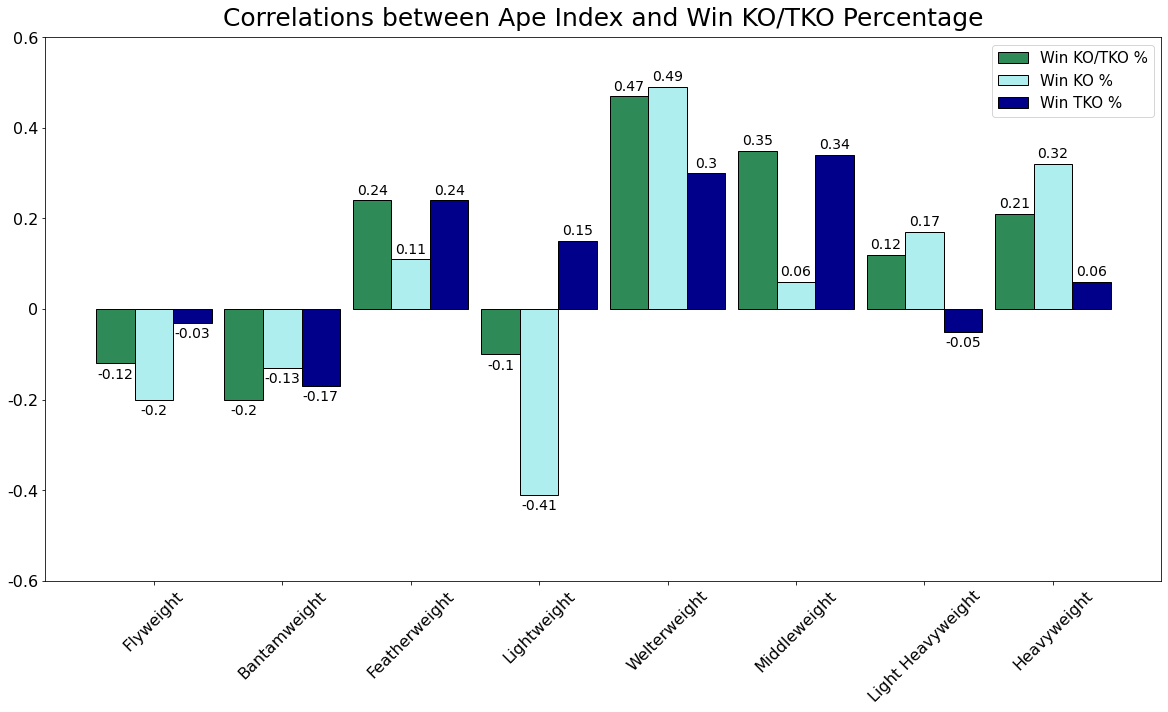

In [22]:
ind = np.arange(8)
width = (0.9)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("Correlations between Ape Index and Win KO/TKO Percentage", fontsize=25, y=1.01)

ko_tko = ax.bar(ind - width / 3, list(striker["Win KO/TKO %"].values), width / 3, color="seagreen", edgecolor="black", label="Win KO/TKO %")
ko = ax.bar(ind, list(striker["Win KO %"].values), width / 3, color="paleturquoise", edgecolor="black", label="Win KO %")
tko = ax.bar(ind + width / 3, list(striker["Win TKO %"].values), width / 3, color="darkblue", edgecolor="black", label="Win TKO %")
        
ax.tick_params(axis="both", which="both", top=False, right=False)
ax.set_xticks(ind)
ax.set_xticklabels(male_divs, fontsize=16, rotation=45)
ax.set_ylim(-0.6, 0.6)
ax.set_yticklabels([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6], fontsize=16)
    
autolabel(ko_tko)
autolabel(ko)
autolabel(tko)

ax.legend(fontsize=15)

plt.show()

The correlation between ape index Index and win KO/TKO percentage is negative for three of the four smallest weight classes yet it is positive for all four of the four largest weight classes. Thus, it appears as though the correlation between ape index and KO/TKO percentage is greatly depends on the weight class.

## 4. Champions

In this section, I will examine all eight of the male UFC champions to see if they have any characteristics that make them more exceptional than the contenders within their weight class. First, I will isolate the champions from the male_ranks dataset by only selecting athletes with a rank of 0.

In [23]:
stats = ["Name", "Division", "UFC Fights", "Win %", "Win Finish Rate", "Win KO/TKO %", 
         "Win Sub %", "Height", "Reach", "Ape Index", "Age", "Country"]

male_champions = male_ranks[male_ranks["Rank"] == 0]
male_champions = male_champions[stats]

Next, I will calculate the averages for target statistics amongst the top 15 ranked contenders for each division.

In [24]:
stats = ["UFC Fights", "Win %", "Win Finish Rate", "Win KO/TKO %", 
         "Win Sub %", "Height", "Reach", "Ape Index", "Age", "Weights"]

male_contenders = male_ranks[male_ranks["Rank"] > 0].groupby("Division").agg(np.mean)
male_contenders = male_contenders[stats].round(3)
stats.remove("Ape Index")
male_contenders[stats] = male_contenders[stats].round(1)
male_contenders = male_contenders.sort_values(by="Weights")
male_contenders = male_contenders.drop(columns="Weights")

In [25]:
male_champions

,Name,Division,UFC Fights,Win %,Win Finish Rate,Win KO/TKO %,Win Sub %,Height,Reach,Ape Index,Age,Country
0,Deiveson Figueiredo,Flyweight,11,90.0,77.8,44.4,33.3,65.0,68.0,1.046,33,Brazil
16,Petr Yan,Bantamweight,7,100.0,57.1,57.1,0.0,66.0,67.0,1.015,27,Russia
32,Alexander Volkanovski,Featherweight,9,100.0,33.3,33.3,0.0,66.0,71.5,1.083,32,Australia
48,Khabib Nurmagomedov,Lightweight,13,100.0,53.8,15.4,38.5,70.0,70.0,1.000,32,Russia
64,Kamaru Usman,Welterweight,12,100.0,25.0,16.7,8.3,72.0,76.0,1.056,33,Nigeria
80,Israel Adesanya,Middleweight,9,100.0,44.4,44.4,0.0,76.0,80.0,1.053,31,Nigeria
96,Jan Błachowicz,Light Heavyweight,15,66.7,60.0,40.0,20.0,74.0,78.0,1.054,37,Poland
112,Stipe Miocic,Heavyweight,17,82.4,64.3,64.3,0.0,76.0,80.0,1.053,38,United States


In [26]:
male_contenders

,UFC Fights,Win %,Win Finish Rate,Win KO/TKO %,Win Sub %,Height,Reach,Ape Index,Age
Division,,,,,,,,,
Flyweight,6.5,70.5,49.6,20.8,28.9,66.1,68.0,1.028,29.6
Bantamweight,11.9,71.6,45.4,31.8,13.6,66.9,67.9,1.016,31.7
Featherweight,11.3,82.1,50.3,33.1,17.1,69.6,71.3,1.025,30.3
Lightweight,15.9,72.6,67.1,42.7,24.3,69.4,72.4,1.043,32.3
Welterweight,15.8,74.4,57.6,36.2,21.4,71.5,74.1,1.036,33.5
Middleweight,12.3,70.0,55.3,44.7,10.5,72.3,75.2,1.041,31.2
Light Heavyweight,8.7,74.4,77.1,51.4,25.8,75.3,77.2,1.024,30.6
Heavyweight,11.1,69.7,68.0,59.0,9.0,75.4,78.9,1.046,34.2


A few things stand out as unique while examining the champions:
- Despite the fact that almost half of the UFC male athletes in the top 15 are from the United States, Stipe Miocic is the only American champion.
    - There are two Russian and two Nigerian UFC male champions.
    - Note that the two Nigerian-born champions emigrated from Nigeria at a very young age (Kamaru was raised in the United States, Isreal was raised in New Zealand).
- 5 out of 8 of the UFC champions are undefeated in the UFC.
    - Khabib and Israel are the only undefeated MMA champions as the other champions with a 100% win percentage suffered losses in other MMA organizations.
    - Jan Blachowicz only has a 66.7% win percentage (74.4% is average for the contenders in his division), meaning he has lost a third of his fights (he lost 4 of his first 6 UFC fights but he won 8 of his last 9 UFC fights).
- 6 out of 8 of the UFC champions have a finish rate that is below average for their division.
    - Suggests most champions tend to win fightesr by points than finishes, which is considered a more assured way to win.
    - The flyweight champion has the highest finish rate (at 77.8%) of all champions despite the fact that the contenders in his division have a fairly low finish rate (49.6%).
    - The welterweight champion has the smallest finish rate (25%), which is less than half the average for the contenders in his division (57.6%).
- All of the champions have KO/TKO wins, however 4 of the champions do not have any submission wins.
- 6 out of 8 of the champions have an ape index that is significantly larger than the top ranked conteders in their  weight divisions.
    - The only two champions with smaller ape indices than the average contender are Petr Yan and Khabib Nurmagomedov, who both happen to be Russian.
    - Alexander Volkanovski's ape index (1.083) is much higher than the average contender (1.025) in his division.
- Age doesn't appear to hinder elite athletes from becoming champions.
    - Jan is 6.4 years older than average light heavyweight contender (37 vs 30.6).
    - Petr Yan is 4.7 years younger than the average bantamweight contender (27 vs 31.7).
    - The rest of the champions are within 2 years of the average contender age in their respective divisions.
- The average featherweight contender is taller than the average lightweight contender (69.6 vs 69.4) despite lightweights being ten pounds heavier.
    - Including champions, the average featherweight is 69.3 and the average lightweight is 69.4.
    - After removing the featherweight champion (66 inches tall) and the lightweight champion (70 inches tall) from the dataset, featherweights are slightly taller on average than lightweights.
    - Even though the average featherweight contender is 0.2 inches taller than the average lightweight contender, the average lightweight contender has a 1.1 inch longer reach than the average featherweight contender.

## 5. Where UFC Athletes Were Born

In this section I will examine the locations where UFC athletes were born to see visualize which regions of the world are most likely to product UFC athletes. In this section, I will complete the following steps:
1. Examine UFC athletes by country of origin.
2. Examine UFC athletes by region (state, province, oblast, etc.) of origin.
3. Examine regions that have a unexpectedly high number of UFC athletes.
4. Create a map that visualizes where elite UFC athletes are from.

### a) UFC Athletes by Country

First, I will list the number of elite UFC athletes from each country.

In [27]:
male_ranks["Country"].value_counts()

United States     59
Brazil            20
Russia            11
England            3
Nigeria            3
Australia          3
Jamaica            2
Ukraine            2
New Zealand        2
Mexico             2
Poland             2
Czech Republic     2
Suriname           1
Italy              1
Latvia             1
Ireland            1
Scotland           1
France             1
Cameroon           1
Ecuador            1
Sweden             1
Iran               1
China              1
Austria            1
Iraq               1
Switzerland        1
South Korea        1
Georgia            1
Bulgaria           1
Name: Country, dtype: int64

Of the 128 UFC males athletes ranked within the UFC's top 15, 46.1% were born in the United States, 15.6% were born in Brazil, and 8.6% were born in Russia. Only 29.7% of the UFC's ranked male athletes come from elsewhere in the world. The dominance of American, Brazilian, and Russian martial artistists could be a result of the following:
- Population = Of the countries on the list above, the US is the 2nd most populous, Brazil is the 3rd most populous, and Russia is the 5th most populous.
- Popularity = The United States and Brazil are the two largest markets for the UFC by viewship (partially due to their large populations) and as a result, American and Brazilian children are more likley to aspire to become UFC athletes than those from other countries.
- Martial Arts = American folkstyle wrestling and American-style boxing, Brazilian Jiu-Jitsu, and Russian sambo and freestyle wrestling are considered some of the most effective martial arts in MMA. Additionally, the majority of high-level MMA gyms are located in the USA and Brazil. Many foreign-born MMA athletes will move to train in one of the two countries.
- American Company = Since the UFC is an American company, it is much easier to select athletes from the United States as doing so avoids visa issues and travel restrictions.

### b) UFC Athletes by Region

Next, I will examine the top 15 regions with the highest number of elite UFC athletes.

In [28]:
male_ranks["Region"].value_counts()[:15]

California         11
Rio de Janeiro      7
Dagestan            7
New York            6
Hawaii              4
Colorado            4
New Jersey          3
Louisiana           3
Sao Paulo           3
New South Wales     3
Illinois            3
Texas               3
Lagos               2
Ohio                2
Arizona             2
Name: Region, dtype: int64

Although California has the most UFC athletes by a considerable margin, this is rather unsurprising considering how highly-represented Americans are in the UFC and that California is the most populous US state with around 40 million people. However, the fact that there are many elite UFC athletes from Dagestan and Hawaii is unexpected considering both regions have rather small populations.

### c) Examining Dagestani and Hawaiian Athletes

Dagestan is a small republic in southern Russia known for their wrestling culture and for having beautiful mountains. Despite only having around 3 million inhabitants, it has 7 ranked UFC athletes, one of which is the lightweight champion. Thus, despite only making up around 2% of the Russian population, Dagestan is the birthplace of 63.6% of Russia's ranked UFC athletes. 

Hawaii is a US state that consists of an archipelago of islands. It is an incredibly popular tourist destination for Americans and is one of the most beautiful places in the world. Despite having only around 1.4 million inhabitants, it has 4 ranked UFC athletes, one of which was the former featherweight champion. Thus, despite only making up around 0.4% of the US population, Hawaii is the birthplace of 6.8% of American's ranked UFC athletes.

I will the athletes from both of these regions to determine if additional information helps explain why these two regions are so highly represented in the UFC. I will start with the Dagestani athletes.

In [29]:
columns = ["Name", "Division", "Rank", "UFC Fights", "Win %", "Finish Rate", 
           "Win KO/TKO %", "Win Sub %", "Height", "Reach", "Ape Index", "Age"]

male_ranks.loc[male_ranks["Region"] == "Dagestan", columns]

,Name,Division,Rank,UFC Fights,Win %,Finish Rate,Win KO/TKO %,Win Sub %,Height,Reach,Ape Index,Age
3,Askar Askarov,Flyweight,3,3,100.0,0.0,0.0,0.0,66.0,67.0,1.015,28
35,Zabit Magomedsharipov,Featherweight,3,6,100.0,50.0,0.0,50.0,73.5,73.0,0.993,29
48,Khabib Nurmagomedov,Lightweight,0,13,100.0,53.8,15.4,38.5,70.0,70.0,1.000,32
61,Islam Makhachev,Lightweight,13,8,87.5,37.5,14.3,28.6,70.0,70.0,1.000,29
93,Omari Akhmedov,Middleweight,13,13,66.7,15.4,25.0,0.0,72.0,73.0,1.014,33
107,Magomed Ankalaev,Light Heavyweight,11,6,83.3,66.7,80.0,0.0,75.0,75.0,1.000,28
120,Shamil Abdurakhimov,Heavyweight,8,8,62.5,25.0,40.0,0.0,75.0,76.0,1.013,39


A couple interesting trends emerge when examining the Dagestani athletes:
- One of the Dagestanis in champion (Khabib) and two of the Dagestanis (Askar and Zabit) are in the top 3 of their divisions.
- Three out of seven of the Dagestanis are undefeated in the UFC.
- Five out of seven of the Dagestanis have a significantly lower finishing rate (at least 10% lower) than is average for their respective divisions (Zabit's and Magomed's finishing rates are around average).
- All Dagestanis (except for Magomed) have a low KO percentage compared to their respective divisions.
- Zabit is very tall for his division (73.5 vs 69.1 inches). Even though he has a negative ape index (0.993), his reach is still longer than the average for his division (73 vs 70.9 inches) due to his height.
- Every Dagestani athlete has a very low ape index for their respective divisions. Four of the seven Dagestani athletes have an ape index of 1.0 or lower.

Based on statistical attributes examined above, nothing about the Dagestani athletes seems exceptional. However, a little background knowledge about Dagestan will shed some light on why they are so prevalent in the UFC. Grappling is deeply ingrained into Dagestani culture, and since reach is less useful in grappling than it is in striking, having a short reach is not much of a disadvantage. Dagestani athletes are known for taking their opponents to the ground and beating them with their fists while in top position (a technique commonly known as "ground and pound"). They also are known for having strong chins and thus are very difficult to knock unconscious.

Next I will examine the UFC Hawaiian athletes, of which I know much less about than the Dagestani UFC athletes.

In [30]:
male_ranks.loc[male_ranks["Region"] == "Hawaii", columns]

,Name,Division,Rank,UFC Fights,Win %,Finish Rate,Win KO/TKO %,Win Sub %,Height,Reach,Ape Index,Age
13,Tyson Nam,Flyweight,13,4,50.0,50.0,100.0,0.0,67.0,68.0,1.015,37
33,Max Holloway,Featherweight,1,23,73.9,47.8,52.9,11.8,71.0,69.0,0.972,29
43,Dan Ige,Featherweight,11,9,77.8,33.3,14.3,28.6,67.0,71.0,1.060,29
94,Brad Tavares,Middleweight,14,18,66.7,11.1,16.7,0.0,73.0,74.0,1.014,33


A couple interesting trends emerge when examining the Hawaiian athletes:
- With the exception of Max Holloway, all the Hawaiian athletes are fairly low-ranked (ranked 11-15).
- With the exception of Dan Ige, all the Hawaiian athletes have low ape indices.
- All four of the Hawaiian athletes have lower than average win percentages for their respective divisions.

Again, nothing about these athletes statistical information gives any indication as to why they are so overrepresented in MMA. Perhaps fighting is part of Hawaiian culture in a similar way to it being part of Dagestani culture.

### d) Mapping UFC Birthplaces

My final part of this section will be to create a map that details the birthplaces of all the UFC athletes ranked within the top fifteen. Because I don't have information on each location's coorinates, I manually create a list of lists that contains information on each region with UFC athletes. This list of lists will contain the region's name, the number of athlete's from that region, the longitude and latitude, and whether a UFC champion was born in that region.

In [31]:
rank_locations = [
    ["California", 11, 36.78, -119.42, False],
    ["Rio de Janeiro", 7, -22.91, -43.21, False],
    ["Dagestan", 7, 42.14, 47.10, True],
    ["New York", 6, 43.30, -74.22, False],
    ["Hawaii", 4, 19.90, -155.58, False],
    ["Colorado", 4, 39.55, -105.78, False],
    ["Sao Paulo", 3, -23.55, -46.63, False],
    ["Texas", 3, 31.97, -99.90, False],
    ["Louisiana", 3, 30.98, -91.96, False],
    ["New South Wales", 3, -31.25, 146.92, True],
    ["Illinois", 3, 40.63, -89.40, False],
    ["New Jersey", 3, 40.06, -74.41, False],
    ["Arizona", 2, 34.05, -111.09, False],
    ["Lagos", 2, 6.52, 3.38, True],
    ["Ohio", 2, 40.42, -82.91, True],
    ['Michigan', 2, 44.31, -85.60, False],
    ["Massachusetts", 2, 42.41, -71.38, False],
    ["Minas Gerais", 2, -18.51, -44.56, False],
    ["Amazonas", 2, -3.42, -65.86, False],
    ['Parana', 2, -25.25, -52.02, False],
    ['Auckland', 2, -36.85, 174.76, False],
    ['Jamaica', 2, 18.11, -77.30, False],
    ["North Carolina", 1, 35.76, -79.02, False],
    ["Bohuslän", 1, 57.71, 11.97, False],
    ['Arkansas', 1, 35.20, -91.83, False],
    ["Trentino", 1, 46.07, 11.12, False],
    ["Paramaribo", 1, 5.85, -55.20, False],
    ["Baja California", 1, 30.84, -115.28, False],
    ['Tennessee', 1, 35.52, -86.58, False],
    ['Łódź', 1, 51.76, 19.46, False],
    ['Vienna', 1, 48.21, 16.37, False],
    ["South Moravian", 1, 48.95, 16.77, False],
    ['Alabama', 1, 32.32, -86.90, False],
    ["Amapa", 1, 0.90, -52.00, False],
    ['Wisconsin', 1, 43.78, -88.79, False],
    ['Connecticut', 1, 41.60, -73.09, False],
    ['North West', 1, 53.62, -2.59, False],
    ["West Province", 1, 5.46, 10.80, False],
    ['Hamadan', 1, 34.80, 48.51, False],
    ["Pennsylvannia", 1, 41.20, -77.19, False],
    ["Para", 1, -2.00, -54.93, True],
    ['East of England', 1, 52.59, 0.59, False],
    ['Kharkiv', 1, 49.99, 36.23, False],
    ["Luhansk", 1, 48.57, 39.31, False],
    ['Rostov', 1, 47.24, 39.70, False],
    ["Iowa", 1, 41.88, -93.10, False],
    ['Chechnya', 1, 43.40, 45.72, False],
    ["Edo", 1, 6.63, 5.93, True],
    ["Sverdlovsk", 1, 56.84, 60.65, True],
    ["North Hamgyeong", 1, 36.02, 129.34, False],
    ["Pernambuco", 1, -8.81, -36.95, False],
    ['Santa Catarina', 1, -27.24, -50.22, False],
    ["South Carolina", 1, 33.84, -81.16, False],
    ['Blagoevgrad', 1, 42.02, 23.09, False],
    ["Moscow", 1, 55.76, 37.62, False],
    ['Hradec Králové', 1, 50.21, 15.83, False],
    ["Friborg", 1, 46.81, 7.16, False],
    ["Leinster", 1, 53.32, -7.51, False],
    ['Baghdad', 1, 33.32, 44.37, False],
    ['Kansas', 1, 39.01, -98.48, False],
    ['Manabi', 1, -1.05, -80.45, False],
    ["Chihuahua", 1, 28.63, -106.07, False],
    ['Tbilisi', 1, 41.72, 44.83, False],
    ["Florida", 1, 27.66, -81.52, False],
    ['Virginia', 1, 37.43, -78.66, False],
    ['London', 1, 51.51, -0.13, False],
    ["Riga", 1, 56.95, 24.11, False],
    ['Nebraska', 1, 41.49, -99.90, False],
    ["Pays de la Loire", 1, 47.76, -0.33, False],
    ['North Lanarkshire', 1, 55.87, -3.96, False],
    ["Silesian", 1, 50.10, 18.54, True],
    ['Heilongjiang', 1, 47.12, 128.74, False],
    ["Missouri", 1, 37.96, -91.83, False]
]

locations = pd.DataFrame(rank_locations, columns = ["Region", "Athletes", "Lat", "Lon", "Champ"])

Next I will use the pandas dataframe created above to create a map of these regions. I will include the following details:
- The color and size of the marker will be determined by the number of athletes born in that region. The color will be noted on a white to green scale, with the regions where the most athletes were born being marked green.
- Regions where a champion was born will be marked by a star and colored red while other regions will be marked with a circled and colored based on the white-green color scale.
- I will create additional text information about each champ, including their name, nickname, division, and region where they were born.

/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


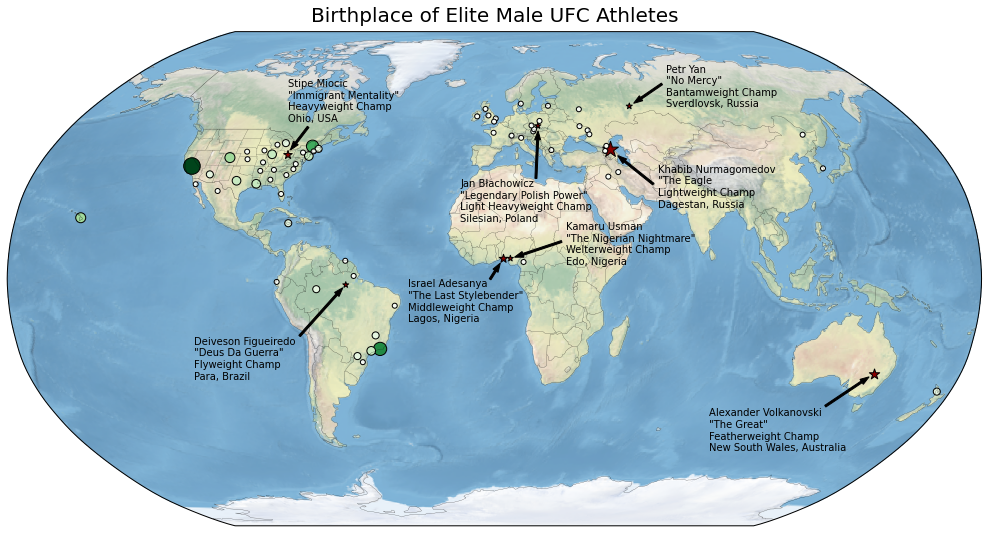

In [32]:
fig = plt.figure(figsize=(20, 20))

# Male UFC Athletes Map
ax = fig.add_subplot(2, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()

ax.set_title("Birthplace of Elite Male UFC Athletes", fontsize=20, pad=10)

champs = locations[locations["Champ"] == True]
non_champs = locations[locations["Champ"] == False]

champ_size = [40*n for n in list(champs["Athletes"])]
other_size = [25*n for n in list(non_champs["Athletes"])]

champ = ax.scatter(x=champs["Lon"], 
                   y=champs["Lat"],
                   c="darkred",
                   s=champ_size,
                   linewidth=1,
                   edgecolor="black",
                   marker="*",
                   vmin=1,
                   vmax=8,
                   transform=ccrs.PlateCarree())

other = ax.scatter(x=non_champs["Lon"], 
                   y=non_champs["Lat"],
                   c=non_champs["Athletes"],
                   cmap="Greens",
                   s=other_size,
                   linewidth=1,
                   edgecolor="black",
                   vmax=9,
                   transform=ccrs.PlateCarree())

# Adding country borders, state borders, and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.1, alpha=0.75)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, alpha=0.75)

# Champion Information
ax.text(-10500000, -3500000, 'Deiveson Figueiredo\n"Deus Da Guerra"\nFlyweight Champ\nPara, Brazil')
ax.arrow(-6800000, -2000000, 1300000, 1450000, width=70000, color="black")

ax.text(6000000, 6000000, 'Petr Yan\n"No Mercy"\nBantamweight Champ\nSverdlovsk, Russia')
ax.arrow(5850000, 6800000, -730000, -500000, width=70000, color="black")

ax.text(7500000, -6000000, 'Alexander Volkanovski\n"The Great"\nFeatherweight Champ\nNew South Wales, Australia')
ax.arrow(11550000, -4450000, 1270000, 850000, width=70000, color="black")

ax.text(5700000, 2500000, 'Khabib Nurmagomedov\n"The Eagle\nLightweight Champ\nDagestan, Russia')
ax.arrow(5550000, 3300000, -1000000, 800000, width=70000, color="black")

ax.text(2500000, 500000, 'Kamaru Usman\n"The Nigerian Nightmare"\nWelterweight Champ\nEdo, Nigeria')
ax.arrow(2350000, 1300000, -1350000, -450000, width=70000, color="black")

ax.text(-3000000, -1500000, 'Israel Adesanya\n"The Last Stylebender"\nMiddleweight Champ\nLagos, Nigeria')
ax.arrow(-150000, -20000, 190000, 300000, width=70000, color="black")

ax.text(-1200000, 2000000, 'Jan Błachowicz\n"Legendary Polish Power"\nLight Heavyweight Champ\nSilesian, Poland')
ax.arrow(1450000, 3500000, 60000, 1350000, width=70000, color="black")

ax.text(-7200000, 5500000, 'Stipe Miocic\n"Immigrant Mentality"\nHeavyweight Champ\nOhio, USA')
ax.arrow(-6500000, 5300000, -430000, -560000, width=70000, color="black")

Now that I have create a map detailing the birthplaces of elite UFC athletes, I will summarize each section on the map:
- United States = Has many more UFC athletes than any other country in the world by a very large margin. As stated earlier, 46.1% of elite UFC athletes were born in the United States.
    - Over half (26) of the US states are represented as the birthplace of a current elite UFC athlete.
    - 12 states have at least two UFC athletes, and 4 states have at least four UFC athletes.
    - California is the birthplace of 11 UFC athletes, which is 8.6% of the total elite UFC athletes. If California were its own country, it would be tied (with Russia) for having the third most elite UFC athletes of any country.
    - Even though the US is the birthplace of many elite UFC athletes, Stipe Miocic is the only American-born champion. However, note that Kamaru Usman, the welterweight champion, is an American citizen and was raised in the United States despite being born in Nigeria.
- Latin America and the Carribean = There are 26 elite UFC athletes from this region, which is 20.3% of the total.
    - 20 out of 26 of these athletes are from Brazil, making up 15.6% of all elite UFC athletes.
    - Rio de Janeiro is the birthplace of 7 UFC athletes and thus is tied (with Dagestan) for having the second-most elite UFC athletes.
- Europe = There are 30 elite UFC athletes born in Europe, making up 23.4% of all athletes in the UFC.
    - These 30 athletes were born in 15 different countries and only five European countries have at least 2 elite UFC athletes (Russia, England, Poland, Ukraine, Czech Republic).
    - Eastern Europe has over twice as many elite UFC athletes as Western Europe does (21 vs 9).
    - Russia has 11 elite UFC athletes, which is 8.6% of the world's total, 36.7% of Europe's total, and 52.4% of Eastern Europe's total.
    - The Caucus region, named after the mountain range, has 9 elite UFC athletes (7 from Dagestan, 1 from Chechnya, and 1 from Georgia).
    - Europe is the birthplace of three champions: bantamweight champion Petr Yan, lightweight champion Khabib Nurmagomedov, and light heavyweight champion Jan Błachovich.
- Africa = Even though Africa is the birthplace of only four elite UFC athletes, two of them are champions.
    - Israel Adesanya (middleweight champion) and Kamaru Usman (welterweight champion) were both born in Nigeria.
    - Francis Ngannou, the #1 ranked heavyweight contender, was born in Cameroon before emigrating to France.
- Asia = Extremely underrepresented in the UFC despite consisting of around 60% of the world's population and being the birthplace of the vast majority of traditional martial arts.
    - Only 4 UFC athletes were born in Asian countries.
    - Most traditional Asian martial arts—Japanese Karate, Korean Taekwondo, Chinese Kung-Fu, etc.—are somewhat utilized in MMA but in most cases have to be incorporated with modern martial arts to become effective.
    - Modernized Asian martial arts—Thai Muay Thai, Japanese Judo, Chinese Sanda, etc.—are considered more effective in MMA.
    - The UFC isn't very popular in Asia and therefore many of the elite Asian athletes are likely fighting for other  MMA organizations, most noteably Singaporean-based One Championship.
- Oceania = Although it only has 5 elite UFC athletes, it is fairly well-represented considering for its small population of around 40 million.
    - Both the featherweight champion (Alexander Volkanovski) and the #1 ranked middleweight contender (Robert Whittaker) were born in New South Wales, Australia.
    - The middleweight champion, Israel Adesanya, was born in Nigeria but was raised in Auckland, New Zealand.
    - City Kickboxing in Auckland, New Zealand was voted Gym of the Year in 2019. Two champions (Alexander Volkanovski and Israel Adesanya) and two other top-ten ranked athletes (Dan Hooker and Kai Kara France) train at City Kickboxing.

## 6. Best MMA Gyms in the World

Next I want plot the MMA gyms where each of the ranked UFC athletes currently train. First, I will create a dictionary that organizes information by mma gym. Each key in this dictionary will be the name of a gym, and the values for each of the keys will be another dictionary containing information about each gym. These informational dictionaries will indicate whether the gym is currently training a champ, the number of ranked UFC fighters currently training at that gym, and a list of lists containing each athletes name, division, and rank in the UFC.

In [33]:
mma_gyms = {}

for x in male_ranks.iterrows():
    row = x[1]
    gym = row["MMA Gym"]
    
    athlete = row["Name"]
    div = row["Division"]
    rank = row["Rank"]
    gym = row["MMA Gym"]
    
    if gym in mma_gyms:
        mma_gyms[gym]["Athletes"].append([athlete, div, rank])
        if rank == 0:
            mma_gyms[gym]["Champ"] = True
        mma_gyms[gym]["Fighters"] += 1
        
    else:
        mma_gyms[gym] = {}
        mma_gyms[gym]["Champ"] = False
        mma_gyms[gym]["Athletes"] = [[athlete, div, rank]]
        if rank == 0:
            mma_gyms[gym]["Champ"] = True
        mma_gyms[gym]["Fighters"] = 1
        
mma_gyms["American Top Team"]

{'Champ': False,
 'Athletes': [['Alexandre Pantoja', 'Flyweight', 5],
  ['Marlon Moraes', 'Bantamweight', 7],
  ['Pedro Munhoz', 'Bantamweight', 8],
  ['Edson Barboza', 'Featherweight', 15],
  ['Dustin Poirier', 'Lightweight', 2],
  ['Jorge Masvidal', 'Welterweight', 4],
  ['Tyron Woodley', 'Welterweight', 6],
  ['Thiago Santos', 'Light Heavyweight', 2],
  ['Aleksandar Rakic', 'Light Heavyweight', 4],
  ['Jairzinho Rozenstruik', 'Heavyweight', 3],
  ['Aleksei Oleinik', 'Heavyweight', 10],
  ['Junior Dos Santos', 'Heavyweight', 11]],
 'Fighters': 12}

As seen above, the MMA gym American Top Team is currently training 12 ranked UFC fighters from 7 of the 8 male divisions and does not have a champ. While this information is useful, I need more information about each gym in order to plot them on a map. I will manually create a dictionary with the following information about each gym:
- The city where the gym is located (needed for textual information).
- The latitude and longitude where the gym is located (needed for plotting the gyms' locations).
- Manually determined coordinates for the start of the textual information.
- Manually determined coordinates for the arrows that will point the textual information to the gyms' physical locations.

Note that due to spacing issues, I will not be able to add textual information for all gyms (there are 64). I will only be adding textual information for the 24 gyms that are currently training more than one ranked UFC athlete.

In [34]:
gym_locations = {"American Top Team": ["Coconut Creek, Florida", 26.2517, -80.1789,
                                       [-6700000, 3600000], [-6725000, 3550000, -495000, -595000]],
                 "Elevation Fight Team": ["Denver, Colorado", 39.7392, -104.9903,
                                          [-9650000, 5400000], [-9500000, 4850000, 255000, -445000]],
                 "Xtreme Couture": ["Las Vegas, Nevada", 36.1699, -115.1398,
                                    [-11600000, 3230000], [-10500000, 3030000, 235000, 675000]],
                 "Eagles MMA": ["Derbent, Dagestan", 42.4549, 45.9293,
                                [3000000, 4250000], [3550000, 4280000, 260000, 170000]],
                 "Sanford MMA": ["Deerfield Beach, Florida", 26.3284, -80.1098, 
                                 [-8550000, 3450000], [-7700000, 2970000, 200000, -90000]],
                 "Serra-Longo Fight Team": ["Garden City, New York", 40.7268, -73.6343,
                                            [-5950000, 4440000], [-5975000, 4410000, -250000, -35000]],
                 "City Kickboxing": ["Auckland, New Zealand", -36.8483, 174.7626,
                                     [3550000, -4500000], [8750000, -4800000, 6100000, 755000]],
                 "Kings MMA": ["Huntington Beach, California", 33.6595, -117.9988,
                               [-11770000, 3900000], np.nan],
                 "Team Alpha Male": ["Sacramento, California", 38.5816, -121.4944,
                                     [-10800000, 4740000], [-10400000, 4330000, -120000, -102000]],
                 "Fortis MMA": ["Dallas, Texas", 32.7767, -96.7970,
                                [-8800000, 4250000], [-8500000, 3840000, -115000, -190000]],
                 "American Kickboxing Academy": ["San Jose, California", 37.3382, -121.8863,
                                                 [-11700000, 5340000], [-11400000, 5000000, 560000, -870000]],
                 "Tristar Gym": ["Montreal, Québec", 45.5017, -73.5673,
                                 [-6300000, 5390000], [-5900000, 5050000, -175000, -110000]],
                 "Roufusport": ["Milwaukee, Wisconsin", 43.0389, -87.9065,
                                [-8300000, 5380000], [-7900000, 5040000, 260000, -330000]],
                 "Alliance MMA": ["San Diego, California", 32.7157, -117.1611,
                                  [-10200000, 3100000], [-10225000, 3070000, -210000, 320000]],
                 "MMA Factory": ["Paris, France", 48.8566, 2.3522, 
                                 [1000000, 5100000], [970000, 5100000, -630000, 90000]],
                 "Tiger Muay Thai": ["Phuket, Thailand", 7.9519, 98.3381,
                                     [3500000, 500000], [7800000, 250000, 950000, 420000]],
                 "Team Tiger Schulmann": ["Elmwood Park, New Jersey", 40.9040, -74.1185,
                                          [-7400000, 4900000], [-7000000, 4630000, 430000, -205000]],
                 "Fight Ready": ["Scottsdale, Arizona", 33.4942, -111.9261, 
                                 [-10100000, 4150000], [-9700000, 3880000, -220000, -200000]],
                 "SBG Ireland": ["Dublin, Ireland", 53.3498, -6.2603,
                                 [-200000, 5000000], [-230000, 5000000, -215000, 545000]],
                 "Lauzon MMA": ["South Easton, Massachussets", 42.0468, -71.0807,
                                [-5850000, 4890000], [-5875000, 4860000, -170000, -240000]],
                 "Factory X Muay Thai": ["Englewood, Colorado", 39.6478, -104.9878,
                                         [-9000000, 4730000], [-8800000, 4460000, -235000, -145000]],
                 "Team Oyama": ["Irvine, California", 33.6846, -117.8265,
                                [-9900000, 3520000], [-9925000, 3410000, -486000, 157000]],
                 "Ricardo Almeida BJJ": ["Washington Township, New Jersey", 39.7561, -75.0728,
                                         [-7200000, 4000000], [-6650000, 4080000, 30000, 47500]],
                 "Team Noguchi": ["Curitiba, Brazil", -25.4290, -49.2671,
                                  [-11000000, -3000000], [-7300000, -3250000, 2200000, 420000]],
                 "Chute Boxe Diego Lima": ["São Paulo, Brazil", -23.5505, -46.6333],
                 "Teixeira MMA & Fitness": ["Bethel, Connecticut", 41.3712, -73.4140],
                 "Black Lion Brazilian Jiu-Jitsu": ["Byron Center, Michigan", 42.8123, -85.7228],
                 "MMA LAB": ["Phoenix, Arizona", 33.4484, -112.0740],
                 "Evolve MMA": ["Singapore, Singapore", 1.3521, 103.8198],
                 "Gracie Jiu-Jitsu Academy": ["Torrance, California", 33.8358, -118.3406],
                 "Pitch Black MMA": ["Simpsonville, South Carolina", 34.7371, -82.2543],
                 "Entram Gym": ["Tijuana, Mexico", 32.5149, -117.0382],
                 "Strong Style Fight Team": ["Independence, Ohio", 41.3687, -81.6379],
                 "Cage Combat Academy": ["Victorville, California", 34.5362, -117.2928],
                 "Luttrell-Yee MMA": ["Albuquerque, New Mexico", 35.0844, -106.6504],
                 "4oz Fight Club": ["Houston, Texas", 29.7604, -95.3698],
                 "PMA Super Martial Arts": ["Padstow, Australia", -33.9505, 151.0309],
                 "Stewie's House of BJJ": ["East Bendigo, Australia", -36.7430, 144.3194],
                 "Ascension MMA": ["Alpharetta, Georgia", 34.0754, -84.2941],
                 "MMA Masters": ["Miami, Florida", 25.6617, -80.1918],
                 "Allstar Training Center": ["Stockholm, Sweden", 59.3293, 18.0686],
                 "Akhmat Fight Club": ["Grozny, Russia", 43.3188, 45.6865],
                 "Sports Lab": ["Portland, Oregon", 45.5051, -122.6750],
                 "Phalanx MMA Academy": ["Fort Worth, Texas", 32.7555, -97.3308],
                 "Ankos MMA": ["Poznań, Poland", 52.4064, 16.9252],
                 "Westside MMA": ["Little Rock, Arkansas", 34.7465, -92.2896],
                 "SBG Alabama": ["Birmingham, Alabama", 33.5186, -86.8104],
                 "London Shootfighters": ["London, England", 51.5074, -0.1278],
                 "Frontline Academy": ["Oslo, Norway", 59.9139, 10.7522],
                 "Gracie Technics": ["Honolulu, Hawaii", 21.3069, -157.8583],
                 "Sik Jitsu Fighting Systems": ["Spokane, Washington", 47.6588, -117.4260],
                 "Team Renegade BJJ & MMA": ["Birmingham, England", 52.4862, -1.8904],
                 "Nova União": ["Rio de Janeiro, Brazil", -22.9068, -43.1729],
                 "Team Lloyd Irvin": ["Camp Springs, Maryland", 38.8040, -76.9066],
                 "Berkut WCA Fight Team": ["Warsaw, Poland", 52.2297, 21.0122],
                 "Strela Team": ["Moscow, Russia", 55.7558, 37.6173],
                 "All Sports Academy": ["Hradec Králové, Czech Republic", 50.2104, 15.8252],
                 "Long Island MMA": ["Farmingdale, New York", 40.7326, -73.4454],
                 "Team Kaobon": ["Liverpool, England", 53.4084, -2.9916],
                 "Glendale Fighting Club": ["Glendale, California", 34.1425, -118.2551],
                 "Scottish Hit Squad": ["Coatbridge, Scotland", 55.8622, -4.0193],
                 "Jetsaam Gym Brno": ["Brno, Czech Republic", 49.1951, 16.6068],
                 "Cerrado MMA": ["Brasília, Brazil", -15.8267, -47.9218],
                 "Freestyle Fighting Gym": ["Wollongong, Australia", -34.6278, 150.6931],
                 "Team Figueiredo": ["Belém, Brazil", -1.4557, -48.4902],
                 "10th Planet Jiu Jitsu": ["Ventura, California", 34.2805, -119.2945],
                 "Demian Maia Jiu-Jitsu": ["São Paulo, Brazil", -24.0630, -47.8227],
                 "Industrials": ["Donetsk, Ukraine", 48.0159, 37.8028]
                }


Now that I have additional information on each gym, I will add this information to my mma_gyms dictionary. Then I will convert it into a pandas dataframe so I can organize the data more easily.

In [35]:
for key, value in gym_locations.items():
    mma_gyms[key]["City"] = value[0]
    mma_gyms[key]["Lat"] = value[1]
    mma_gyms[key]["Lon"] = value[2]
    
    if len(value) > 3:
        mma_gyms[key]["Text Placement"] = value[3]
        mma_gyms[key]["Arrow Placement"] = value[4]
    
gyms = pd.DataFrame.from_dict(mma_gyms, orient="index")
gyms = gyms.sort_values("Fighters", ascending=False)

gyms.head()

,Champ,Athletes,Fighters,City,Lat,Lon,Text Placement,Arrow Placement
American Top Team,False,"[[Alexandre Pantoja, Flyweight, 5], [Marlon Mo...",12,"Coconut Creek, Florida",26.2517,-80.1789,"[-6700000, 3600000]","[-6725000, 3550000, -495000, -595000]"
Xtreme Couture,False,"[[Joseph Benavidez, Flyweight, 2], [Tim Elliot...",6,"Las Vegas, Nevada",36.1699,-115.1398,"[-11600000, 3230000]","[-10500000, 3030000, 235000, 675000]"
Elevation Fight Team,False,"[[Cory Sandhagen, Bantamweight, 2], [Justin Ga...",6,"Denver, Colorado",39.7392,-104.9903,"[-9650000, 5400000]","[-9500000, 4850000, 255000, -445000]"
Eagles MMA,False,"[[Askar Askarov, Flyweight, 3], [Islam Makhach...",5,"Derbent, Dagestan",42.4549,45.9293,"[3000000, 4250000]","[3550000, 4280000, 260000, 170000]"
Sanford MMA,True,"[[Kamaru Usman, Welterweight, 0], [Gilbert Bur...",5,"Deerfield Beach, Florida",26.3284,-80.1098,"[-8550000, 3450000]","[-7700000, 2970000, 200000, -90000]"


Now I finally have enough information to create the plot of all the MMA gyms ranked UFC athletes use to train. Because there are so many MMA gyms in the United States in Europe, I will be creating two subplots detailing the gyms in those two areas for readability purposes.

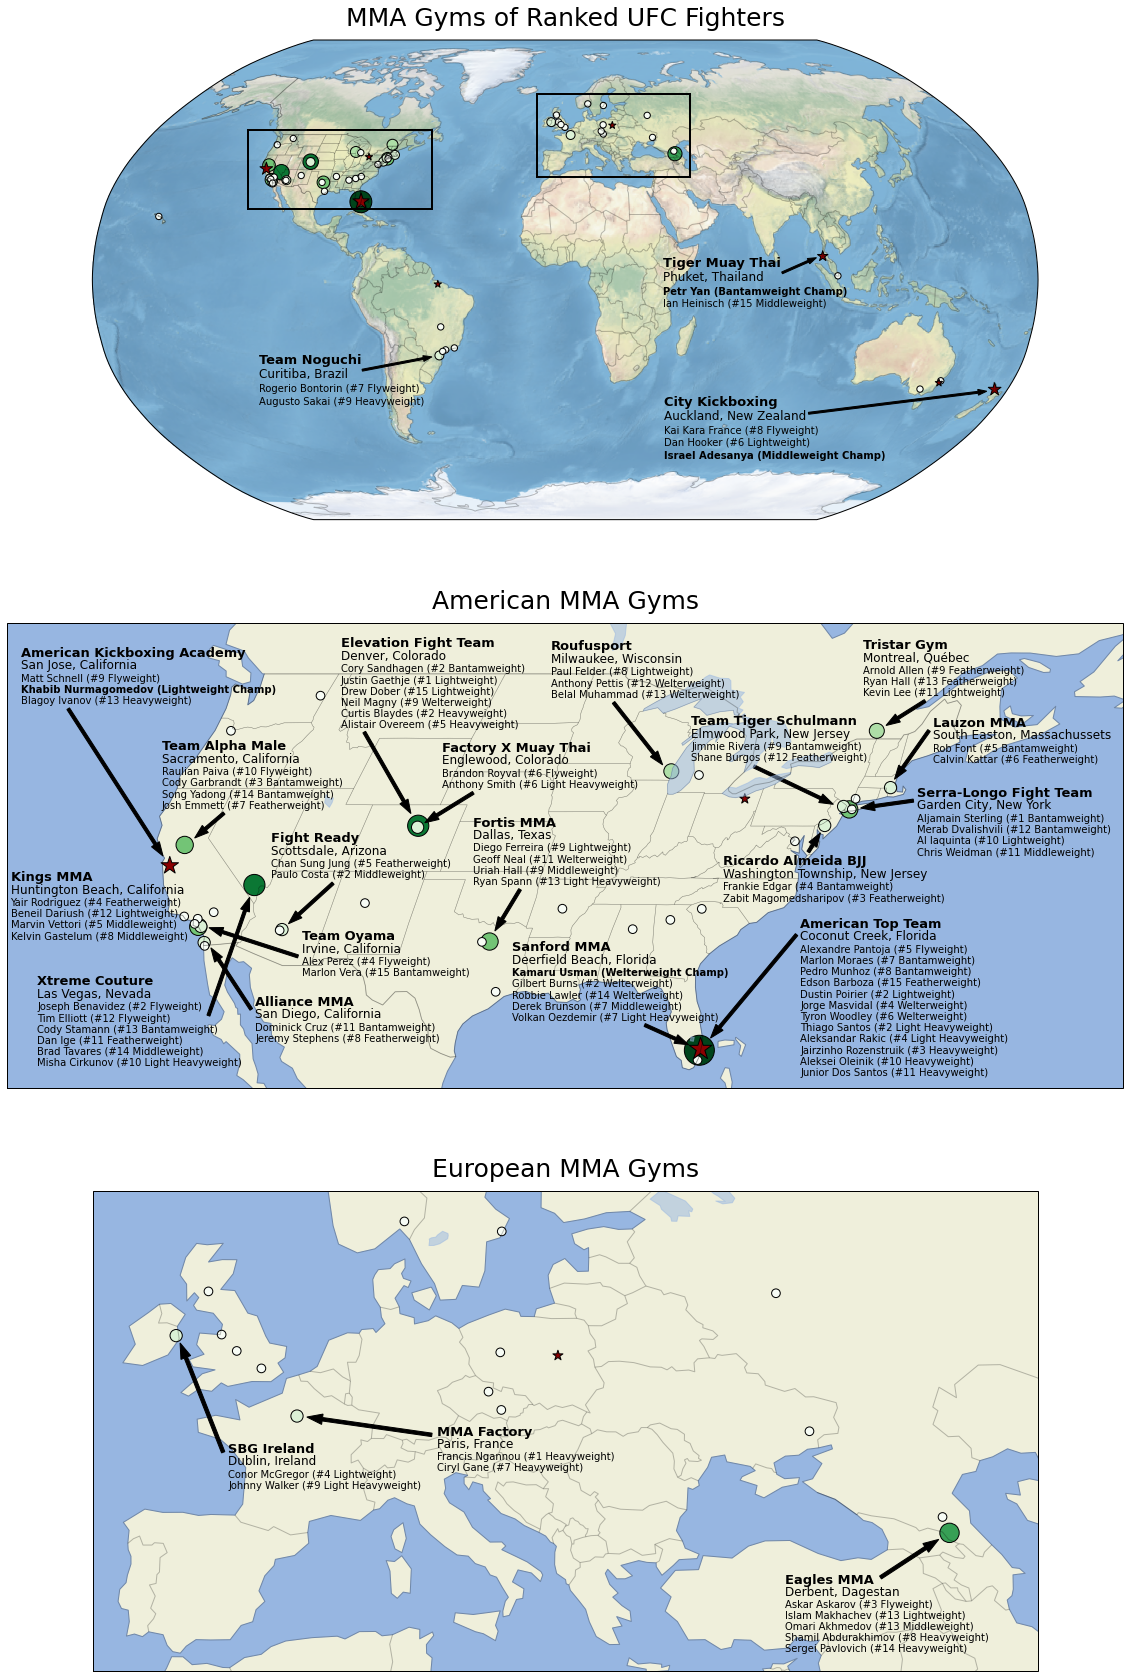

In [36]:
fig = plt.figure(figsize=(20, 30))

info = {"title": ["MMA Gyms of Ranked UFC Fighters",
                  "American MMA Gyms",
                  "European MMA Gyms"],
        "coords": [[-128, -55, 24, 46],
                   [-11, 50, 35, 58]],
        "marker": [40, 75, 75]}

# Subsets for gyms with champs and those without champs
champs = gyms[gyms["Champ"] == True]
non_champs = gyms[gyms["Champ"] == False]

# Creating all three plots
for sp in range(3):
    
    # Subplot
    ax = fig.add_subplot(3, 1, sp + 1, projection=ccrs.Robinson())
    
    # Coordinate range and image features vary by plot
    if sp == 0:
        ax.set_global()
        ax.stock_img()
    else:
        ax.set_extent(info["coords"][sp - 1])
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        ax.add_feature(cfeature.OCEAN)
    
    # Title
    ax.set_title(info["title"][sp], fontsize=25, pad=10, y=1.01)

    # Country borders, state borders, and coastlines
    ax.add_feature(cfeature.BORDERS, linewidth=1.0, alpha=0.25)
    ax.add_feature(cfeature.STATES, linewidth=0.5, alpha=0.25)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, alpha=0.25)
    
    # Size of the markers
    champ_size = [info["marker"][sp]*n*1.5 for n in list(champs["Fighters"])]
    other_size = [info["marker"][sp]*n for n in list(non_champs["Fighters"])]
    
    # Gym locations without champs
    ax.scatter(x=non_champs["Lon"], 
               y=non_champs["Lat"],
               c=non_champs["Fighters"],
               cmap="Greens",
               s=other_size,
               linewidth=1,
               edgecolor="black",
               vmax=7,
               transform=ccrs.PlateCarree())

    # Gym locations with champs
    ax.scatter(x=champs["Lon"], 
               y=champs["Lat"],
               c="darkred",
               s=champ_size,
               linewidth=1,
               edgecolor="black",
               marker="*",
               vmax=7,            
               transform=ccrs.PlateCarree())
    
    # Locations of US and European plots on world map
    if sp == 0:
        rect_us = patches.Rectangle((-11400000,2550000),6600000,2850000,linewidth=2,edgecolor='black',facecolor='none')
        rect_eur = patches.Rectangle((-1000000,3700000),5500000,3000000,linewidth=2,edgecolor='black',facecolor='none')

        ax.add_patch(rect_us)
        ax.add_patch(rect_eur)
    
    # Subsets of data for world, us, and european text info
    world_gyms = gyms[gyms["Lat"] < 25]
    us_gyms = gyms[gyms["Lat"] > 25]
    eur_gyms = us_gyms[us_gyms["Lon"] > -40]
    us_gyms = us_gyms[us_gyms["Lon"] < -40]
        
    # Function that displays info for all gyms
    def text_control(sub_gym, space, arrow_width):
        for gym in sub_gym.iterrows():
            name = gym[0]
            row = gym[1]
            count = row["Fighters"]
            athletes = row["Athletes"]
            text = row["Text Placement"]
            arrow = row["Arrow Placement"]
            city = row["City"]

            # Will display gym information if a gym is training more than one ranked UFC athlete
            if count > 1:
                ax.text(text[0], text[1], name, fontsize=13, fontweight="bold")
                ax.text(text[0], text[1] - space, city, fontsize=12)

                for n, athlete in enumerate(athletes):
                    new_space = space * 0.9
                    
                    if athlete[2] == 0:
                        rank = athlete[1] + " Champ"
                        bold = "bold"
                    else:
                        rank = "#" + str(athlete[2]) + " " + athlete[1]
                        bold = "normal"
                    ax.text(text[0], text[1] - (new_space * n) - (2 * space), athlete[0] + " (" + rank + ")", fontweight=bold)
                if arrow == arrow:
                    ax.arrow(arrow[0], arrow[1], arrow[2], arrow[3], width=arrow_width, color="black")
    
    # Places text information on the appropriate plot
    if sp == 0:
        spacing = 500000
        width = 70000
        text_control(world_gyms, spacing, width)
    elif sp == 1:
        spacing = 80000
        width = 20000
        text_control(us_gyms, spacing, width)
    else:
        spacing = 70000
        width = 20000
        text_control(eur_gyms, spacing, width)

After examining the gyms of the ranked UFC athletes, I have come to the following conclusions:
- The vast majority of UFC athletes train at MMA gyms in the United States.
    - Of the 68 MMA gyms that train ranked UFC fighters, 38 of them are in the United States (55.9%).
    - Of the 128 ranked UFC athletes, 86 of them train at an MMA gym in the United States (67.2%).
    - Although only one current UFC champion was born in the United States, three UFC champions train in the United States.
- The main MMA gyms in the United States are centralized in California, the Miami metropolitan area, the Denver metropolitan area, and the New York City metropolitan area.
    - There are 9 Californian MMA gyms (23.7% of the US total) and 19 ranked UFC athletes train there (22.1% of the US total), including one champion. 
    - There are 3 MMA gyms in the Miami metropolitan area and 17 ranked UFC male athletes train there (19.8% of the US total), including one champion.
- The majority of gyms in Europe and Oceania only train a single ranked UFC athlete.
    - There are 19 MMA gyms in Europe that elite MMA athletes train at in Europe and Oceania, but only 4 of them are currently training more than one ranked UFC athlete.
    - There are 22 UFC atheltes training in Europe even though 30 athletes were born in Europe, meaning many European-born fighters train outside of Europe.
    - On the other hand, all five of the fighters born in Oceania train in the country where they were born.
- There are large sections of the globe where ranked UFC athletes don't train.
    - Not a single ranked UFC athlete trains in Africa (all four UFC athletes born in Africa have since emmigrated elsewhere).
    - Not a single ranked UFC athlete trains in an Asian country outside of Southeast Asia.
    - Brandon Moreno is the only ranked UFC athlete trains that trains in Hispanic America (Spanish-speaking Latin American countries), and he trains in Tijuana, Mexico, which is on the US-Mexican border.
- Only three gyms outside of the United States (Eagles MMA in Dagestan, City Kickboxing in Auckland, and Tristar Gym in Montreal) are currently training more than two ranked UFC fighters.
    - Eagles MMA = Founded by Abdulmanap Nurmagomedov (deceased), the father of current UFC lightweight champion Khabib Nurmagomedov, and currently ran by Khabib. Khabib, his main training partner Islam Makhachev (#13 ranked lightweight), and many other Dagestni-born athletes train at both American Kickboxing Academy in San Jose and Eagles MMA in Dagestan. 
    - City Kickboxing = Ran by Eugene Bareman and head gym of UFC champion Isreal Adesanya. Featherweight champion Alexander Volkanovski also occasionally completes his training camps at City Kickboxing.
    - Tristar Gym = Ran by Firas Zahab and home gym of retired UFC welterweight/middleweight champion George St-Pierre, one of the greatest mixed martial artists of all time.

## 7. Unique Fighters in the UFC

Next, I will examine extremities for many of the statistics examined ealier. For example, I will analyze the UFC fighters with the most UFC fights, the oldest fighters, the fighters with the highest finish rates, etc. 

### a) Number of Fights in the UFC

First, I will examine ranked fighters with at least 25 UFC fights as well as ranked fighters with 3 or less UFC fights. 

In [37]:
cols = ["Name", "Division", "Rank", "UFC Fights", "Win %", "Age", "Country"]
male_ranks.loc[male_ranks["UFC Fights"] >= 25, cols].sort_values("UFC Fights", ascending=False)

,Name,Division,Rank,UFC Fights,Win %,Age,Country
40,Jeremy Stephens,Featherweight,8,33,46.9,34,United States
71,Demian Maia,Welterweight,7,32,68.8,43,Brazil
55,Rafael Dos Anjos,Lightweight,7,30,63.3,36,Brazil
20,Frankie Edgar,Bantamweight,4,27,69.2,39,United States
51,Charles Oliveira,Lightweight,3,27,69.2,31,Brazil


Jeremy Stephens has fought more UFC fights than any other ranked fighter in the UFC, which is second only to he is  Donald Cerrone (who is currently unranked and has 34 UFC fights) for most fights in UFC history.

All of the fighters above have a win percentage that is less than average for their respective divisions, and Jeremy Stephens even has a losing record. Unexpectedly, two of the fighters on this list (Rafael Dos Anjos and Frankie Edgar) are former lightweight champions (Edgar has moved down two weight classes since he was champion). As expected, most of these fighters have aged past their fighting primes, however Charles Oliveira is only 31 and thus well within his best fighting years. He could very easily surpass Stephens and Cerrone for most fights in UFC history.

Every fighter on this list has fought at multiple weightclasses and has fought in the UFC for at least 10 years. Of the fighters on this list, Charles Oliveira is most likley to become champion, although both Frankie Edgar and Rafael Dos Anjos could potentially win the belt as well despite their age. Oliveira is currently in his fighting prime, on an 8 fight winning streak (of which 7 wins were finishes), and as of December 31, 2020 is only one win away from a title shot.

Next I will examine ranked UFC fighters with the fewest number of UFC fights.

In [38]:
male_ranks.loc[male_ranks["UFC Fights"] <= 3, cols].sort_values("UFC Fights")

,Name,Division,Rank,UFC Fights,Win %,Age,Country
15,Amir Albazi,Flyweight,15,1,100.0,27,Iraq
101,Jiri Prochazka,Light Heavyweight,5,1,100.0,28,Czech Republic
11,David Dvorak,Flyweight,11,2,100.0,28,Czech Republic
3,Askar Askarov,Flyweight,3,3,100.0,28,Russia
6,Brandon Royval,Flyweight,6,3,66.7,28,United States
79,Khamzat Chimaev,Welterweight,15,3,100.0,26,Russia
126,Sergei Pavlovich,Heavyweight,14,3,66.7,28,Russia


Most of the ranked male fighters with less than 3 UFC fights are in divisions that have a very small rosters and thus are fairly uncompetitive (flyweight, light heavyweight, heavyweight). The only exception is Khamzat Chimaev, who is ranked at welterweight (one of the most competitive divisions) despite only fighting three times in the UFC. This is likely due to the nature of his wins (which were exceptionally dominante), his undefeated MMA record of 9-0, and the fact that he has finished every opponent he has ever fought in MMA.

Interestingly, there are three Russian and two Czech fighters on this list. Perhaps the UFC is focusing its recruitment efforts on fighters from Eastern Europe, a region considerd to be a goldmine of untapped MMA talent by many MMA experts.

### b) Ranked Fighters with Undefeated UFC Records (At Least Five UFC Fights)

Before exmamining this next section, I will create a subset of UFC fighters who have fought in the UFC at least five times. This will help me ensure that fighters with a very low number of UFC fights don't skew the data. For example, a fighter with only two UFC fights, one win, and one draw is technically undefeated, even though few MMA analysts would be impressed by this record. 

I will examine all ranked UFC fighters who have had at least five fights in the UFC and are still undefeated. Due to how competitive the UFC is compared to most other MMA organizations, this is a very impressive feat. Note that this does not mean that a fighter's MMA record is undefeated, but rather that they haven't lost a UFC fight.

In [39]:
five_fights = male_ranks.loc[male_ranks["UFC Fights"] >= 5]

In [40]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Win Finish Rate", "Age", "Country"]
five_fights.loc[five_fights["Win %"] == five_fights["Win %"].max(), cols].sort_values("UFC Fights", ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,Win Finish Rate,Age,Country
48,Khabib Nurmagomedov,Lightweight,0,13,13,53.8,32,Russia
64,Kamaru Usman,Welterweight,0,12,12,25.0,33,Nigeria
32,Alexander Volkanovski,Featherweight,0,9,9,33.3,32,Australia
80,Israel Adesanya,Middleweight,0,9,9,44.4,31,Nigeria
16,Petr Yan,Bantamweight,0,7,7,57.1,27,Russia
41,Arnold Allen,Featherweight,9,7,7,28.6,26,England
30,Song Yadong,Bantamweight,14,6,5,60.0,23,China
35,Zabit Magomedsharipov,Featherweight,3,6,6,50.0,29,Russia
42,Sodiq Yusuff,Featherweight,10,5,5,40.0,27,Nigeria
46,Bryce Mitchell,Featherweight,14,5,5,20.0,26,United States


Unsurprisingly, 5 of the 10 of the UFC fighters who are undefeated in the UFC are also champions. Note that only Khabib Nurmagomedov, Israel Adesanya, and Bryce Mitchell are undefeated in MMA as a whole. However, all of the fighters on this list except for Song Yadong (who's MMA record is 16-4-1 (1)) are either undefeated in MMA or have only lost a single MMA fight in their entire career.

Interestingly, three undefeated fighters with at least five UFC fights are from Nigeria. Since there are only three ranked Nigerian fighters in the UFC, this means all of the ranked UFC fighters from Nigeria are undefeated in the UFC.

There are also two undefeated ranked athletes from Dagestan. Note that Askar Askarov, who is also from Dagestan, is also undefeated (in both the UFC and MMA as a whole), however he is not on this list as he has only fought three times in the UFC. As noted in an earlier section, a lot of MMA talent from Dagestan has been flooding into the UFC over the past few years, largely due to the effors of Khabib Nurmagomedov, his late father Abdulmanap Nurmagomedov, and their elite MMA gym Eagles MMA.

It is also important to note that most of these undefeated fighters have low finish rates. Since finishing a fight is normally considered the more risky way to win, as you leave yourself more open to get KO'ed or submitted by your opponent, it makes sense that most undefeated fighters prefer cruising to a decision win rather than finishing their opponents.

### c) Ranked Fighters with Losing UFC Records (At Least Five UFC Fights)

Now I will analyze the ranked UFC fighters with at least five UFC fights who have more UFC losses than they have UFC wins. The fact that fighters with losing records could remain ranked in the UFC is unexpected, so I hypothesize that these fighters are in divisions with less competition, such as the flyweight, light heavyweight, or heavyweight divisions.

In [41]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Win %", "Win Finish Rate", "Age", "Country"]
five_fights.loc[five_fights["Win %"] < 50, cols].sort_values("Win %")

,Name,Division,Rank,UFC Fights,UFC Wins,Win %,Win Finish Rate,Age,Country
12,Tim Elliott,Flyweight,12,8,3,37.5,33.3,34,United States
125,Blagoy Ivanov,Heavyweight,13,5,2,40.0,0.0,34,Bulgaria
124,Walt Harris,Heavyweight,12,15,6,42.9,100.0,37,United States
40,Jeremy Stephens,Featherweight,8,33,15,46.9,53.3,34,United States


As expected, three of these fighters are in uncompetitive divisions. However, Jeremy Stephens is ranked at featherweight despite having a losing record. Looking at his record, it appears as though he is currently on a four-fight losing streak and all four of those losses have come against other highly-ranked opponents. Since a fighter's rank doesn't change if they lose to a higher-ranked opponent, this could explain why his ranking hasn't decreased in the last few years despite having a losing UFC record.

Additionally, all of these fighters are at least 34 years old, meaning they are past their fighting prime and thus highly unlikely to improve their performance. Of all ranked UFC fighters, these fighters are the most likely to get cut from the organization, especially considering all of them are on losing streaks (have lost their last two or more fights) except for Tim Elliott.

### d) Most Draws and No Contests

Next I will determine which ranked UFC fighters have the most draws and NC's in the UFC. Unlike in boxing, fights very rarely end by either draw or NC, so there should only be a dozen or so fighters with a draw or NC on their record.

In [42]:
cols = ["Name", "Division", "UFC Fights", "UFC Wins", "UFC Losses", "UFC Draws", "Country"]
male_ranks.loc[male_ranks["UFC Draws"] > 0, cols].sort_values("UFC Draws", ascending=False)

,Name,Division,UFC Fights,UFC Wins,UFC Losses,UFC Draws,Country
1,Brandon Moreno,Flyweight,10,6,2,2,Mexico
0,Deiveson Figueiredo,Flyweight,11,9,1,1,Brazil
3,Askar Askarov,Flyweight,3,2,0,1,Russia
20,Frankie Edgar,Bantamweight,27,18,8,1,United States
29,Cody Stamann,Bantamweight,8,5,2,1,United States
30,Song Yadong,Bantamweight,6,5,0,1,China
60,Beneil Dariush,Lightweight,18,13,4,1,Iran
69,Stephen Thompson,Welterweight,16,11,4,1,United States
70,Tyron Woodley,Welterweight,15,9,5,1,United States
84,Darren Till,Middleweight,10,6,3,1,England


There are 13 ranked fighters with a draw on their record and Brandon Moreno is the only ranked fighter in the UFC with two draws. Interestingly, he only has ten fights in the UFC, which isn't many compared to most fighters in the organization. He also received his draws fighting two ranked fighters on this list: Deiveson Figueiredo and Askar Askarov.

Next I will examine all of the ranked UFC fighters who have had at least one NC in the UFC. No contests are incredibly rare and usually occur because one fighter landed an unintentional illegal blow that prevented the fight from continuing or because the winner of the fight tested positive for a banned substance in a post-fight drug test.

In [43]:
cols = ["Name", "Division", "UFC Fights", "UFC Wins", "UFC Losses", "UFC NC", "Country"]
male_ranks.loc[male_ranks["UFC NC"] == five_fights["UFC NC"].max(), cols].sort_values("UFC Fights", ascending=False)

,Name,Division,UFC Fights,UFC Wins,UFC Losses,UFC NC,Country
40,Jeremy Stephens,Featherweight,33,15,17,1,United States
51,Charles Oliveira,Lightweight,27,18,8,1,Brazil
50,Dustin Poirier,Lightweight,24,18,5,1,United States
88,Kelvin Gastelum,Middleweight,17,10,6,1,United States
63,Drew Dober,Lightweight,15,9,5,1,United States
124,Walt Harris,Heavyweight,15,6,8,1,United States
24,Pedro Munhoz,Bantamweight,14,8,5,1,Brazil
114,Curtis Blaydes,Heavyweight,12,9,2,1,United States
36,Yair Rodriguez,Featherweight,10,8,1,1,Mexico
34,Brian Ortega,Featherweight,9,7,1,1,United States


There are 11 ranked UFC fighters with a NC on their record. The reasons for the NC's are as follows:
- Stephens vs Rodriguez = Rendered a NC because Rodriguez landed an unintentional eyepoke that left Stephens unable to continue.
- Oliveira vs Lentz = Originally a submission win for Oliveira but was overturned due to an illegal knee.
- Poirer vs Alvarez = Rendered a NC because Alvarez landed an illegal knee.
- Gastelum vs Belfort = Originally a TKO win for Gastelum but overturned when Gastelum tested positive for marijuana.
- Dober vs Silva = Originally a submission win for Silva but overturned due to a referee error.
- Harris vs Arlovski = Originally a split decision win for Harris but overturned when Harris tested postiive for PED's.
- Munhoz vs Sanders = Originally a submission win for Munhoz but overturned when Munhoz tested positive for exogenous origin of testosterone.
- Blaydes vs Milstead = Originally a TKO win for Blaydes but overturned when Blaydes tested positive for marijuana.
- Ortega vs De La Torre = Originally a submission win for Ortega but overturned when Ortega tested postiive for PED's.
- Hill vs Abreu = Originally a TKO win for Hill but overturned after he tested positive for marijuana.

Marijuana, PED's and testosterone use, and unintentional fouls are the leading causes of no contests. Draws and No Contests are incredibly rare in the UFC due to the nature of the UFC's point system and the unlikely series of events required to end a fight in No Contest.

### e) Ranked Fighters with 100% Win Finish Rates (At Least Five UFC Fights)

Next I will examine all fighters that have had at least five UFC fights and have finished all of their winning fights. Note that this does not mean they have finished all of their fights (none of these fighters are undefeated), but rather it means that they have never won a fight by decision. Fighters that finish a large percentage of their wins are usually considered exciting fighters by the majority of the UFC fanbase.

In [44]:
cols = ["Name", "Division", "UFC Fights", "UFC Wins", "Win %",
        "Win KO/TKO %", "Win Sub %", "Country"]
five_fights.loc[five_fights["Win Finish Rate"] == five_fights["Win Finish Rate"].max(), cols].sort_values("Win %", ascending=False)


,Name,Division,UFC Fights,UFC Wins,Win %,Win KO/TKO %,Win Sub %,Country
108,Jimmy Crute,Light Heavyweight,6,5,83.3,60.0,40.0,Australia
113,Francis Ngannou,Heavyweight,12,10,83.3,90.0,10.0,Cameroon
115,Jairzinho Rozenstruik,Heavyweight,6,5,83.3,100.0,0.0,Suriname
37,Chan Sung Jung,Featherweight,9,6,66.7,66.7,33.3,South Korea
106,Misha Cirkunov,Light Heavyweight,9,6,66.7,16.7,83.3,Latvia
49,Justin Gaethje,Lightweight,8,5,62.5,100.0,0.0,United States
110,Paul Craig,Light Heavyweight,11,6,60.0,16.7,83.3,Scotland
124,Walt Harris,Heavyweight,15,6,42.9,100.0,0.0,United States


There are a grand total of 10 fighters that have finished all of their winning fights. As expected, most of the fighters on the table above are from the heavier weight classes. Of these fighters, the most impressive is Francis Ngannou, who has finished 10 out his 12 UFC opponents. He also has the most powerful punch of any fighter currently in the UFC.

Unsurprisingly, most of these fighters are from either the light heavyweight or heavyweight divisions, which have the two highest finish rates of any weight division. The two fighters from other divisions are known for having impressive knockout power for their size.

Three fighters have finished 100% of their winning fights via KO (knockout artists) and two fighters have finished 83.3% of their fights via submission (submission specialists). While Jimmy Crute and Chan Sung Jung appear to be well-rounded fighters, Francis Ngannou is also clearly a knockout artist as he's finished 90% of his wins via knockout. 

Note that win percentage and finish rate might be different despite the fact that these fighters have won all of their wins because unlike finish rate, win percentage doesn't account for draws or no contests.

### f) Ranked Fighters that Have Never Finished a Fight (At Least Five UFC Fights)

Next I will examine the fighters with at least five UFC fights who have never finished a fight despite having fought in the UFC at least five times.

In [45]:
five_fights.loc[five_fights["Finish Rate"] == five_fights["Finish Rate"].min(), cols].sort_values("Win %", ascending=False)


,Name,Division,UFC Fights,UFC Wins,Win %,Win KO/TKO %,Win Sub %,Country
28,Merab Dvalishvili,Bantamweight,7,5,71.4,0.0,0.0,Georgia
29,Cody Stamann,Bantamweight,8,5,71.4,0.0,0.0,United States
8,Kai Kara France,Flyweight,6,4,66.7,0.0,0.0,New Zealand
125,Blagoy Ivanov,Heavyweight,5,2,40.0,0.0,0.0,Bulgaria


There are only four ranked fighters with at least five UFC fights that have never finished a fight. Other than Blagoy (who has a losing UFC record), most are from lighter weight divisions, which have lower finish rates.

### g) Most Wins

In this subsection, I will examine ranked fighters with the most overall UFC wins.

In [46]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Win %",
        "Win Finish Rate", "Win KO/TKO %", "Win Sub %", "Age", "Country"]
five_fights.loc[five_fights["UFC Wins"] >=16, cols].sort_values("UFC Wins", ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,Win %,Win Finish Rate,Win KO/TKO %,Win Sub %,Age,Country
71,Demian Maia,Welterweight,7,32,22,68.8,54.5,4.5,50.0,43,Brazil
55,Rafael Dos Anjos,Lightweight,7,30,19,63.3,42.1,21.1,21.1,36,Brazil
20,Frankie Edgar,Bantamweight,4,27,18,69.2,38.9,27.8,11.1,39,United States
50,Dustin Poirier,Lightweight,2,24,18,78.3,61.1,38.9,22.2,31,United States
51,Charles Oliveira,Lightweight,3,27,18,69.2,88.9,11.1,77.8,31,Brazil
33,Max Holloway,Featherweight,1,23,17,73.9,64.7,52.9,11.8,29,United States
73,Neil Magny,Welterweight,9,23,17,73.9,35.3,29.4,5.9,33,United States


Interestingly, all of these fighters are from either the United States or Brazil. A decade ago, when many of these fighters were signed to the UFC, the vast majority of UFC recuritment was in the United States and Brazil as only these two countries had elite MMA gyms.

Also noteworthy is that none of the fighters with the most wins are current champions, although three are former champions and one is a former interim champion. This is likely because once fighters win the championship belt, they oftentimes reduce how frequently they fight in order to maximize the amount of money they make per fight. Once a UFC fighter becomes a champion, he or she only fights on PPV cards (where athletes make the most money by far), and there are only 12 PPV cards per year. Due to the limited amount of PPV cards, there are only around 20-25 title fights every year. Since there are eight male champions, three female champions, and one Conor McGregor, UFC champions usually only fight 1-2 times per year, and having 3 or more title fights per division every year is very rare. For example, only four fighters who ended 2020 as a champion fought more than once. Only Israel Adesanya, Jan Błachovich, and Valentina Schevchenko (women's flyweight champion) fought twice in 2020, and Daveison Figuiredo fought four times in 2020.

Interestingly, three of these fighters are still in their fighting prime and ranked in the top 3. Dustin Poirier, Charles Oliveira, and Max Holloway could very easily break the record for the most UFC wins if they continue to win at their current rates.

### h) Most Finishes and Highest Finish Rate (At Least Five UFC Fights)

Next, I will look at the ranked UFC fighters with the most finishes and the fighters with the highest finish rates.

In [47]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Finishes",
        "KO/TKO Wins", "Sub Wins", "Win Finish Rate", "Age", "Country"]

five_fights.loc[five_fights["Finishes"] >=11, cols].sort_values("Finishes", ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,Finishes,KO/TKO Wins,Sub Wins,Win Finish Rate,Age,Country
51,Charles Oliveira,Lightweight,3,27,18,16,2,14,88.9,31,Brazil
71,Demian Maia,Welterweight,7,32,22,12,1,11,54.5,43,Brazil
97,Glover Teixeira,Light Heavyweight,1,20,15,12,6,6,80.0,41,Brazil
33,Max Holloway,Featherweight,1,23,17,11,9,2,64.7,29,United States
50,Dustin Poirier,Lightweight,2,24,18,11,7,4,61.1,31,United States
53,Tony Ferguson,Lightweight,5,18,15,11,5,6,73.3,36,United States
74,Vicente Luque,Welterweight,10,15,12,11,8,3,91.7,29,United States
98,Thiago Santos,Light Heavyweight,2,20,13,11,11,0,84.6,36,Brazil
116,Derrick Lewis,Heavyweight,4,20,15,11,11,0,73.3,35,United States


Again, all of these fighters are either American or Brazilian. All fighters are ranked in the top 10 and 7 out of 10 are ranked within the top five. Every fighter except for Demian Maia has a high win finish rate for their weight division.

Charles Oliveira has the most finishes by a considerable margin, as he has 4 more finishes than Maia and Teixeira. Unlike Maia and Teixeira, he is also young, meaning he is highly likely to continue to extend his finishing record. He also has an incredibly 14 submission wins, which is 26.9% of all submission wins the sixteen ranked lightweights have accumulated during their UFC careers. He also has finished nearly 90% of all his wins.

The three fighters with the most finishes are all Brazilian and have a very high win submission percentage. After examining further, all are very highly ranked in Brazilian Jiu-Jitsu. Oliveira has a 3rd degree BJJ black belt, Maia has a 4th degree BJJ black belt, and Teixiera has a 2nd degree BJJ black belt.

About half of the fighters on this list are well-rounded while the other half are specialists. Charles Oliveira and Demian Maia are submission specialists while Thiago Santos and Derrick Lewis are KO/TKO artists.

Next I will examine the ranked UFC fighters with the highest finishing rates.

In [48]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Finishes", 
        "Win %", "Finish Rate", "Win KO/TKO %", "Win Sub %", "Age", "Country"]
five_fights.loc[five_fights["Finish Rate"] >=70, cols].sort_values(["Finish Rate", "Finishes"], ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,Finishes,Win %,Finish Rate,Win KO/TKO %,Win Sub %,Age,Country
113,Francis Ngannou,Heavyweight,1,12,10,10,83.3,83.3,90.0,10.0,34,Cameroon
108,Jimmy Crute,Light Heavyweight,12,6,5,5,83.3,83.3,60.0,40.0,24,Australia
115,Jairzinho Rozenstruik,Heavyweight,3,6,5,5,83.3,83.3,100.0,0.0,32,Suriname
74,Vicente Luque,Welterweight,10,15,12,11,80.0,73.3,66.7,25.0,29,United States
62,Gregor Gillespie,Lightweight,14,7,6,5,85.7,71.4,50.0,33.3,33,United States
75,Geoff Neal,Welterweight,11,7,6,5,85.7,71.4,66.7,16.7,30,United States


All of these fighters have around the same win percentage (between 80% and 86%) and three fighters have finished all of their wins. However, only two of these fighters have a rank better than 10. This means that most of these fighters have yet to win against top-ranked UFC competition, which will likely bring down their finish rates. Stephen Thompson (the #5 ranked welterweight) won his last two fights, which happened to be against Vicente Luque and Geoff Neil, who are both listed above. Thompson's wins brought down both Luque and Neil's finish rates.

### i) Most KO/TKO's and Highest Win KO/TKO's Rate (At Least Five UFC Fights)

Next I will examine the fighters with the most KO/TKO's as well as the fighters with the highest KO/TKO rate.

In [49]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Finishes", "KO/TKO Wins",
        "Win %", "Win Finish Rate", "Win KO/TKO %", "Age", "Country"]

five_fights.loc[five_fights["KO/TKO Wins"] >= 9, cols].sort_values(["KO/TKO Wins", "Win KO/TKO %"], ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,Finishes,KO/TKO Wins,Win %,Win Finish Rate,Win KO/TKO %,Age,Country
98,Thiago Santos,Light Heavyweight,2,20,13,11,11,65.0,84.6,84.6,36,Brazil
116,Derrick Lewis,Heavyweight,4,20,15,11,11,75.0,73.3,73.3,35,United States
123,Junior Dos Santos,Heavyweight,11,23,15,10,10,65.2,66.7,66.7,36,Brazil
113,Francis Ngannou,Heavyweight,1,12,10,10,9,83.3,100.0,90.0,34,Cameroon
117,Alistair Overeem,Heavyweight,5,19,12,9,9,63.2,75.0,75.0,40,England
112,Stipe Miocic,Heavyweight,0,17,14,9,9,82.4,64.3,64.3,38,United States
33,Max Holloway,Featherweight,1,23,17,11,9,73.9,64.7,52.9,29,United States


All of the fighters listed above are KO/TKO artists, and only two fighters on the list even have submission wins. Most of the fighters are heavyweights, although one fighters is a light heavyweight and the other is unexpectedly a featherweight. All of the fighters on this list are past their fighting primes except for Max Holloway, who could easily break the record for most KO/TKO wins by the time his career ends.

In [50]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "KO/TKO Wins",
        "Win %", "Win Finish Rate", "Win KO/TKO %", "Age", "Country"]

five_fights.loc[five_fights["Win KO/TKO %"] >= 81, cols].sort_values(["Win KO/TKO %", "KO/TKO Wins"], ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,KO/TKO Wins,Win %,Win Finish Rate,Win KO/TKO %,Age,Country
124,Walt Harris,Heavyweight,12,15,6,6,42.9,100.0,100.0,37,United States
49,Justin Gaethje,Lightweight,1,8,5,5,62.5,100.0,100.0,32,United States
115,Jairzinho Rozenstruik,Heavyweight,3,6,5,5,83.3,100.0,100.0,32,Suriname
113,Francis Ngannou,Heavyweight,1,12,10,9,83.3,100.0,90.0,34,Cameroon
98,Thiago Santos,Light Heavyweight,2,20,13,11,65.0,84.6,84.6,36,Brazil
83,Jared Cannonier,Middleweight,3,11,6,5,54.5,83.3,83.3,36,United States


Interestingly, almost all of the fighters on this list are ranked in the top 3 of their respective divisions. This is rather surprising as champions usually have lower finishing rate than contenders (as winning by decision is less risky). Of all these athletes, three have already fought for the title (all three came up short). However, Francis Ngannou will receive his second title shot in 2021 and he is the clear betting favorite to win. 

### j) Most KO's in the UFC

Next I will examine ranked fighters that have the most KO's in the UFC. KO's are much less common than TKO's because usually the ref will stop the fight before a fighter knocks their opponent unconscious. Generally speaking, a higher  KO rate indicates that a fighter has greater knockout power for his respective division.

In [51]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "KO/TKO Wins",
        "KO Wins", "Win %", "Win KO/TKO %", "Win KO %", "Age", "Country"]

five_fights.loc[five_fights["KO Wins"] >= 4, cols].sort_values("KO Wins", ascending=False).sort_values(["KO Wins", "Win KO %"], ascending=False)


,Name,Division,Rank,UFC Fights,UFC Wins,KO/TKO Wins,KO Wins,Win %,Win KO/TKO %,Win KO %,Age,Country
54,Dan Hooker,Lightweight,6,15,10,6,5,66.7,60.0,50.0,30,New Zealand
74,Vicente Luque,Welterweight,10,15,12,8,5,80.0,66.7,41.7,29,United States
113,Francis Ngannou,Heavyweight,1,12,10,9,4,83.3,90.0,40.0,34,Cameroon
40,Jeremy Stephens,Featherweight,8,33,15,8,4,46.9,53.3,26.7,34,United States
116,Derrick Lewis,Heavyweight,4,20,15,11,4,75.0,73.3,26.7,35,United States
123,Junior Dos Santos,Heavyweight,11,23,15,10,4,65.2,66.7,26.7,36,Brazil


Unexpectedly, Dan Hooker and Vicente Luque have the most KO's and the two highest win KO percentages despite being from fairly light weightclasses. Jeremy Stephens, a featherweight, also has a lot of KO power. Francis Ngannou, who has greater KO power than any fighter in the UFC, has finished 40% of his fights via KO and another 50% of his fights via TKO. Unfortunately Yoel Romero (who has 5 KO wins despite only fighting 13 times in the UFC) was recently dropped from the UFC and thus is not represented in this dataset.

### k) Youngest and Oldest Ranked UFC Fighters (At Least Five UFC Fights)

Next I will examine both the youngest and oldest ranked UFC fighters. Note that a fighter's prime athletic years are usually between 27-32, although this greatly varies on what age the fighter turns professional and how much physical damage they have taken over the years.

In [52]:
cols = ["Name", "Division", "Rank", "UFC Fights", "UFC Wins", "Win %",
        "Win Finish Rate", "Win KO/TKO %", "Win Sub %", "Birthday", "Age", "Country"]
five_fights.loc[five_fights["Age"] <= 25, cols].sort_values("Birthday").sort_values("Birthday", ascending=False)

,Name,Division,Rank,UFC Fights,UFC Wins,Win %,Win Finish Rate,Win KO/TKO %,Win Sub %,Birthday,Age,Country
30,Song Yadong,Bantamweight,14,6,5,100.0,60.0,40.0,20.0,1997-12-02,23,China
92,Edmen Shahbazyan,Middleweight,12,6,5,83.3,80.0,60.0,20.0,1997-11-20,23,United States
108,Jimmy Crute,Light Heavyweight,12,6,5,83.3,100.0,60.0,40.0,1996-03-04,24,Australia
10,Raulian Paiva,Flyweight,10,5,3,60.0,33.3,33.3,0.0,1995-10-17,25,Brazil


The youngest ranked UFC fighters are 23 years old, which is the same age Jon Jones (the youngest ever UFC champion) became champion. Both are very lowly ranked but have very good win percentages, meaning they both have a great chance of developing into potential title challengers in the future.

Jimmy Crute, who is only 24, has an incredibly high win percentage as well as a perfect win finish rate. He also appears seems to be well-rounded as he has nearly an even number of KO/TKO and submission wins. He will be a very interesting fighter to watch develop.

Next I will take a look at the oldest ranked UFC fighters.

In [53]:
five_fights.loc[male_ranks["Age"] >= 40, cols].sort_values("Birthday")

,Name,Division,Rank,UFC Fights,UFC Wins,Win %,Win Finish Rate,Win KO/TKO %,Win Sub %,Birthday,Age,Country
122,Aleksei Oleinik,Heavyweight,10,13,8,61.5,87.5,12.5,75.0,1977-06-25,43,Ukraine
71,Demian Maia,Welterweight,7,32,22,68.8,54.5,4.5,50.0,1977-11-06,43,Brazil
97,Glover Teixeira,Light Heavyweight,1,20,15,75.0,80.0,40.0,40.0,1979-10-28,41,Brazil
117,Alistair Overeem,Heavyweight,5,19,12,63.2,75.0,75.0,0.0,1980-05-17,40,England


Aleksei Oleinik is the oldest fighter in the UFC, with Demian Maia only around 4 months younger. Both are 43 years old, making them 20 years older than the youngest ranked fighters in the UFC. Demian Maia has the most UFC wins of any ranked fighter and although Aleksei Oleinik doesn't have that many UFC fights, he has 74 professional MMA fights and fought his first professional MMA fight in 1996.

The top three fighters on this list all have an extremely high submission win percentages. After investigating further, Maia is a 4th degree black belt in Brazilian jiu-jitsu, Oleinik is a 4th degree black belt in traditional jiu-jitsu, and Glover Teixeira is a 2nd degree black belt in Brazilian jiu-jitsu. This suggests grapplers are able to remain competitive at an older age.

Of the four ranked UFC fighters in their 40's, Glover Teixeira has the best chance of winning a title as he is the current #1 ranked light heavyweight contenders. He will likely fight the winner of Jan Błachovich vs. Israel Adesanya (who is trying to become a double champion), a fight that will happen in March 2021. Alistair Overeem also stands a chance of winning the title, although he has noteably lost to four of the five fighters ranked higher than him so it will be very difficult for him to do so.

### l) Shortest and Tallest Ranked UFC Fighters

Next I will examine the shortest and tallest ranked fighters in the UFC. First I will look at the shortest fighters.

In [54]:
cols = ["Name", "Division", "Rank", "Height", "Reach", "Ape Index", "Country"]
male_ranks.loc[male_ranks["Height"] <= 65, cols].sort_values("Height")

,Name,Division,Rank,Height,Reach,Ape Index,Country
2,Joseph Benavidez,Flyweight,2,64.0,65.0,1.016,United States
8,Kai Kara France,Flyweight,8,64.0,69.0,1.078,New Zealand
25,Jimmie Rivera,Bantamweight,9,64.0,68.0,1.062,United States
0,Deiveson Figueiredo,Flyweight,0,65.0,68.0,1.046,Brazil
5,Alexandre Pantoja,Flyweight,5,65.0,68.0,1.046,Brazil
7,Rogerio Bontorin,Flyweight,7,65.0,67.0,1.031,Brazil
11,David Dvorak,Flyweight,11,65.0,68.0,1.046,Czech Republic
15,Amir Albazi,Flyweight,15,65.0,68.0,1.046,Iraq


The shortest fighters in the UFC are only 5'4", and almost all of them are flyweights. 5'4" is the same height as former flyweight/bantamweight double champion Henry Cejudo, who retired as champion. It is also one inch taller than former flyweight Demetrious Johnson, who has the UFC record for most title defenses at 11 in any division. 

It is unlikely that these athlete's short stature is a hindering their performance. The current champion, Daveison Figueiredo, is only one inch taller than the shortest ranked fighters in the UFC. Additionally, all but one of the athletes on this list have fairly long ape indices, which likely assists them in fighting taller opponents.

Next I will examine the tallest fighters in the UFC.

In [55]:
male_ranks.loc[male_ranks["Height"] >= 77, cols].sort_values("Height", ascending=False)

,Name,Division,Rank,Height,Reach,Ape Index,Country
118,Alexander Volkov,Heavyweight,6,79.0,80.0,1.013,Russia
105,Johnny Walker,Light Heavyweight,9,78.0,82.0,1.051,Brazil
109,Ryan Spann,Light Heavyweight,13,77.0,79.0,1.026,United States
119,Ciryl Gane,Heavyweight,7,77.0,81.0,1.052,France
124,Walt Harris,Heavyweight,12,77.0,77.0,1.000,United States


The tallest ranked UFC fighter is 6'7", which is the same height as the average basketball player in the NBA. Only five ranked fighters in the UFC are 6'5" or taller, and none of them are ranked within the top 5. Note that the three best heavyweight boxers in the world at this time are all very tall: Tyson Fury is 6'9", Anthony Joshua is 6'6", and Deontay Wilder is 6'7". Considering the top-five ranked heavyweights are all considerably shorter than Volkov (between 6'2" and 6'4", not to mention the heavyweight champion before Stipe was only 5'11"), height is probably less useful in MMA than it is in basketball and boxing.

### m) Fighters with the Longest Reaches

Next I will examine the fighters with the longest reaches. Note that all of these fighters have a shorter reach than Jon Jones (at 84.5 inches), who is absent from this list because he vacated his light heavyweight championship belt and is currently planning on moving up to heavyweight.

In [56]:
cols = ["Name", "Division", "Rank", "Win Finish Rate", "Win KO/TKO %", "Win KO %",
        "Win Sub %", "Height", "Reach", "Ape Index", "Country"]

male_ranks.loc[male_ranks["Reach"] >= 81, cols].sort_values("Reach", ascending=False)

,Name,Division,Rank,Win Finish Rate,Win KO/TKO %,Win KO %,Win Sub %,Height,Reach,Ape Index,Country
126,Sergei Pavlovich,Heavyweight,14,100.0,100.0,50.0,0.0,75.0,84.0,1.120,Russia
113,Francis Ngannou,Heavyweight,1,100.0,90.0,40.0,10.0,76.0,83.0,1.092,Cameroon
105,Johnny Walker,Light Heavyweight,9,80.0,80.0,40.0,0.0,78.0,82.0,1.051,Brazil
90,Kevin Holland,Middleweight,10,55.6,44.4,11.1,11.1,75.0,81.0,1.080,United States
119,Ciryl Gane,Heavyweight,7,75.0,25.0,0.0,50.0,77.0,81.0,1.052,France


All five of these fightesr have a high win finish rate and a high win KO/TKO percentage, which is unsurprising as a long reach enables an athlete to hit their opponent from farther away. They also all have incredibly high ape indices, especially Sergei Pavlovich. Despite the fact that Pavlovich is 4 inches shorter than Alexander Volkov's, his reach is 4 inches longer.

### n) Fighters with the Longest and Shortest Ape Indices

Next I will take a look at fighters with both the longest and the shortest ape indices and compare them to one another.

In [57]:
male_ranks.loc[male_ranks["Ape Index"] >= 1.08, cols].sort_values("Ape Index", ascending=False)

,Name,Division,Rank,Win Finish Rate,Win KO/TKO %,Win KO %,Win Sub %,Height,Reach,Ape Index,Country
126,Sergei Pavlovich,Heavyweight,14,100.0,100.0,50.0,0.0,75.0,84.0,1.120,Russia
59,Kevin Lee,Lightweight,11,63.6,27.3,9.1,36.4,69.0,77.0,1.116,United States
89,Uriah Hall,Middleweight,9,77.8,77.8,11.1,0.0,72.0,79.5,1.104,Jamaica
83,Jared Cannonier,Middleweight,3,83.3,83.3,16.7,0.0,71.0,77.5,1.092,United States
113,Francis Ngannou,Heavyweight,1,100.0,90.0,40.0,10.0,76.0,83.0,1.092,Cameroon
32,Alexander Volkanovski,Featherweight,0,33.3,33.3,0.0,0.0,66.0,71.5,1.083,Australia
122,Aleksei Oleinik,Heavyweight,10,87.5,12.5,12.5,75.0,74.0,80.0,1.081,Ukraine
90,Kevin Holland,Middleweight,10,55.6,44.4,11.1,11.1,75.0,81.0,1.080,United States


Again, Jon Jones would be on this list if he had not vacated the light heavyweight belt. He is 6'4" and has a 84.5 inch reach, meaning his ape index is 1.112, which would be third highest if he was included in the dataset. Half of these fighters have a KO percentage that is much higher (at least 20 percentage points) than average for their respective divisions, although the other half have a lower KO percentage that is around or lower than average for their respective divisions. Perhaps a high ape index is only useful for KO's if an athlete's gameplan is to knock out his opponent.

Next I will look at the ranked fighters with the lowest ape indices in the UFC.

In [58]:
five_fights.loc[male_ranks["Ape Index"] <= 0.99, cols].sort_values("Ape Index", ascending=True)

,Name,Division,Rank,Win Finish Rate,Win KO/TKO %,Win KO %,Win Sub %,Height,Reach,Ape Index,Country
29,Cody Stamann,Bantamweight,13,0.0,0.0,0.0,0.0,66.0,64.0,0.970,United States
33,Max Holloway,Featherweight,1,64.7,52.9,5.9,11.8,71.0,69.0,0.972,United States
19,Cody Garbrandt,Bantamweight,3,71.4,71.4,28.6,0.0,67.0,65.5,0.978,United States
4,Alex Perez,Flyweight,4,71.4,28.6,14.3,42.9,66.0,65.0,0.985,United States
12,Tim Elliott,Flyweight,12,33.3,0.0,0.0,33.3,67.0,66.0,0.985,United States
24,Pedro Munhoz,Bantamweight,8,75.0,37.5,12.5,37.5,66.0,65.0,0.985,Brazil
30,Song Yadong,Bantamweight,14,60.0,40.0,20.0,20.0,68.0,67.0,0.985,China
18,Cory Sandhagen,Bantamweight,2,66.7,50.0,0.0,16.7,71.0,70.0,0.986,United States
49,Justin Gaethje,Lightweight,1,100.0,100.0,40.0,0.0,71.0,70.0,0.986,United States


Despite having a low ape index, 7 out of 9 of the fighters listed above have a higher win KO percentage than average for their division. Perhaps ape index is not as useful for knocking out opponents in MMA as I previously assumed.

## 8. Results

The objective of this study was to examine statistical information about all ranked UFC fighters and note which attributes were likely to be correlated with success. Based on my investigation I have concluded the following:
- The flyweight, light heavyweight, and heavyweight divisions have small rosters and likely aren't very competitive
    - In more competitive divisions, fighters need around 5 wins in a row to become ranked.
    - In less competitive divisions, fighters only need a few wins to become ranked, and some ranked fighters even have losing records.
- Ape index, reach, and height are very likely overrated statistics in determining success in MMA.
    - All three statistics are much more important in boxing and thus were likely adopted from boxing without considering the differences between boxing and MMA.
    - All three statistics aren't positively correlated with success in most weight divisions.
    - Ape index is not positively correalted with KO/TKO percentage as originally assumed.
- Larger weight classes are significanlty more likely to end a fight via KO or TKO than smaller weight classes are.
- Only one UFC champion was born in the United States but two were born in Russia and another two were born in Nigeria.
    - Despite there being only one American-born champion, three UFC champions train in the United States.
    - Five out of eight of the UFC champions are undefeated in the UFC.
    - Six out of eight of the UFC champions have lower finish rates than average, which suggests focusing on finishing your opponents isn't a wise strategy to become champion.
    - Six out of eight of the UFC champions have a higher ape index than average.
    - Most champions are either around the same age or older than the average contender, with Petr Yan being the only exception.
- The vast majority of ranked UFC atheltes are either from the United States (46.1%), Brazil (15.6%), or Russia (8.6%).
    - Dagestan has 7 ranked UFC athletes (including one champion) despite being a small Russian republic of around 3 million people.
    - Hawaii has 4 ranked UFC athletes (including one #1 contender) despite being a small American state of around 1.4 million people.
    - Only 4 UFC athletes were born in Asia despite the fact that most people in the world live in Asia.
- Most ranked UFC fighters (67.2%) train at a MMA gym in the United States.
    - California, Miami, Denver, and NYC all have many MMA gyms and train a large number of ranked UFC athletes.
    - Almost all of the large MMA gyms that train more than one ranked UFC athlete are in the United States.
- Most fighters with a 100% win finish rate have a fairly low win percentage for their division.
    - Suggests focusing on ending a fight via finish is a fairly poor strategy for moving up the rankings.
    - However, most fighters with a very high KO/TKO percentage are ranked in the top 3.